In [1]:
import sys 
sys.path.append('..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import torch as ch
from torch import Tensor
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader
from delphi.stats.truncated_regression import truncated_regression
from delphi.utils.datasets import TruncatedRegressionDataset 
from delphi.oracle import Left, Interval
import datetime

In [ ]:
STORE_PATH = '/home/pstefanou/knownVsUnknown'
STORE_TABLE_NAME = 'rebuttal12'

store = Store(STORE_PATH)

store.add_table(STORE_TABLE_NAME, { 
    'known_param_mse': float,
    'unknown_param_mse': float, 
    'ols_param_mse': float,
    'alpha': float, 
    'var': float, 
})

In [2]:
# regression parameters
num_samples, dims = 10000, 10
W = ch.ones(dims, 1)
W0 = ch.ones(1, 1)
phi = Left(Tensor([1.0]))
var = 1.0

# perform each experiment a total of 10 times
for iter_ in range(1):        
#     for var in ra¿nge(1, 20):
    # generate data
    X = MultivariateNormal(ch.zeros(dims), ch.eye(dims)/dims).sample(ch.Size([num_samples]))
    y = X.mm(W) + W0 + Normal(ch.zeros(1), ch.sqrt(Tensor([var]))).sample(ch.Size([num_samples]))
    # truncate
    indices = phi(y).nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = y[indices], X[indices]

    # empirical linear regression
    reg = LinearRegression() 
    reg.fit(x_trunc, y_trunc)
    emp_var = ch.var(ch.from_numpy(reg.predict(x_trunc)) - y_trunc, dim=0).unsqueeze(0)

    # experiment parameters
    args = Parameters({ 
        'alpha': Tensor([y_trunc.size(0)/num_samples]), 
        'phi': phi, 
        'epochs': 25,
        'num_workers': 20, 
        'batch_size': 10,
        'bias': True,
        'num_samples': 100,
        'clamp': True, 
        'radius': 5.0, 
        'var_lr': 1e-2,
        'var': emp_var,
        'lr': 1e-1,
        'shuffle': True
    })


#         # truncated linear regression with known noise variance
#         # dataset 
#         data = TruncatedRegressionDataset(x_trunc, y_trunc, bias=args.bias, unknown=False)
#         S = DataLoader(data, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=args.shuffle)
#         trunc_reg = truncated_regression(phi=phi, alpha=args.alpha, epochs=args.epochs, var_lr=args.var_lr, lr=args.lr, num_samples=args.num_samples, var=args.var, device='cuda')
#         results = trunc_reg.fit(S)
#         w_, w0_ = results.weight.detach(), results.bias.detach()

    # truncated linear regression with unknown noise variance
    # dataset 
    data = TruncatedRegressionDataset(x_trunc, y_trunc, bias=args.bias, unknown=True)
    S = DataLoader(data, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=args.shuffle)
    trunc_reg = truncated_regression(phi=phi, alpha=args.alpha, epochs=args.epochs, var_lr=args.var_lr, lr=args.lr, num_samples=args.num_samples, device='cuda')
    results = trunc_reg.fit(S)
    var_ = results.lambda_.inverse().detach()
    w, w0 = results.v.detach()*var_, results.bias.detach()*var_

    # calculate metrics 
    real_params = ch.cat([W, W0])
    ols_params = ch.cat([data.w, data.w0.unsqueeze(0)])
    unknown_params = ch.cat([w, w0])
#     known_params = ch.cat([w_.t(), w0_.unsqueeze(0)])
    unknown_param_mse = mean_squared_error(unknown_params.cpu(), real_params)
    ols_param_mse = mean_squared_error(ols_params, real_params)
#     known_param_mse = mean_squared_error(known_params.cpu(), real_params)

#     store[STORE_TABLE_NAME].append_row({ 
#         'known_param_mse': known_param_mse,
#         'unknown_param_mse': unknown_param_mse,
#         'ols_param_mse': ols_param_mse,
#         'alpha': float(args.alpha.flatten()),
#         'var': float(var), 
#     })

# close current store
# store.close()

Epoch:1 | Score tensor([-0.0307, -0.1100,  0.0563, -0.1478, -0.0481,  0.0742,  0.0603,  0.0933,
        -0.0557,  0.0264, -0.0876,  0.3214], device='cuda:0') 
Epoch:1 | Score tensor([-0.0307, -0.1100,  0.0563, -0.1478, -0.0481,  0.0742,  0.0603,  0.0933,
        -0.0557,  0.0264, -0.0876,  0.3214], device='cuda:0') 
Epoch:1 | Score tensor([-0.0307, -0.1100,  0.0563, -0.1478, -0.0481,  0.0742,  0.0603,  0.0933,
        -0.0557,  0.0264, -0.0876,  0.3214], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0299, -0.0798,  0.0409, -0.1026, -0.0221,  0.0705,  0.0704,  0.0923,
        -0.0327,  0.0394,  0.0976, -0.1683], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0299, -0.0798,  0.0409, -0.1026, -0.0221,  0.0705,  0.0704,  0.0923,
        -0.0327,  0.0394,  0.0976, -0.1683], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0042, -0.0048,  0.0198, -0.0699, -0.0798, -0.0123,  0.0343,  0.0964,
         0.0680,  0.0430,  0.1733, -0.3932], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0042, -0.0048,  0.0

Epoch:1 | Score tensor([-0.0025,  0.0078,  0.0425,  0.0041,  0.0255, -0.0119, -0.0047, -0.0164,
         0.0016, -0.0085,  0.1292, -0.2524], device='cuda:0') 
Epoch:1 | Score tensor([-0.0018,  0.0088,  0.0355,  0.0012,  0.0310, -0.0168, -0.0063, -0.0174,
         0.0013, -0.0067,  0.1317, -0.2553], device='cuda:0') 
Epoch:1 | Score tensor([-0.0018,  0.0088,  0.0355,  0.0012,  0.0310, -0.0168, -0.0063, -0.0174,
         0.0013, -0.0067,  0.1317, -0.2553], device='cuda:0') 
Epoch:1 | Score tensor([ 1.8363e-03,  7.3041e-03,  3.6936e-02, -2.1698e-04,  2.8130e-02,
        -1.2160e-02, -5.2473e-03, -1.5628e-02,  1.5627e-03, -6.2707e-03,
         1.3154e-01, -2.6182e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 1.8363e-03,  7.3041e-03,  3.6936e-02, -2.1698e-04,  2.8130e-02,
        -1.2160e-02, -5.2473e-03, -1.5628e-02,  1.5627e-03, -6.2707e-03,
         1.3154e-01, -2.6182e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 1.8363e-03,  7.3041e-03,  3.6936e-02, -2.1698e-04,  2.8130e-02,
    

Epoch:1 | Score tensor([-0.0031,  0.0020,  0.0194, -0.0084,  0.0178,  0.0095, -0.0131, -0.0057,                              
         0.0034,  0.0041,  0.1653, -0.3023], device='cuda:0') 
Epoch:1 | Score tensor([-0.0031,  0.0020,  0.0194, -0.0084,  0.0178,  0.0095, -0.0131, -0.0057,
         0.0034,  0.0041,  0.1653, -0.3023], device='cuda:0') 
Epoch:1 | Score tensor([-0.0040,  0.0027,  0.0208, -0.0084,  0.0163,  0.0040, -0.0122, -0.0070,
         0.0011, -0.0022,  0.1640, -0.2936], device='cuda:0') 
Epoch:1 | Score tensor([-0.0040,  0.0027,  0.0208, -0.0084,  0.0163,  0.0040, -0.0122, -0.0070,
         0.0011, -0.0022,  0.1640, -0.2936], device='cuda:0') 
Epoch:1 | Score tensor([-0.0071,  0.0046,  0.0272, -0.0087,  0.0193,  0.0047, -0.0111, -0.0064,
        -0.0019,  0.0051,  0.1734, -0.3177], device='cuda:0') 
Epoch:1 | Score tensor([-0.0071,  0.0046,  0.0272, -0.0087,  0.0193,  0.0047, -0.0111, -0.0064,
        -0.0019,  0.0051,  0.1734, -0.3177], device='cuda:0') 
Epoch:1 | Score 

Epoch:1 | Score tensor([ 0.0116,  0.0104,  0.0202, -0.0067,  0.0077,  0.0012, -0.0142, -0.0109,
         0.0044,  0.0089,  0.1865, -0.3563], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0116,  0.0104,  0.0202, -0.0067,  0.0077,  0.0012, -0.0142, -0.0109,
         0.0044,  0.0089,  0.1865, -0.3563], device='cuda:0') 
Epoch:1 | Score tensor([ 1.1211e-02,  1.1282e-02,  2.0029e-02, -6.3353e-03,  7.6180e-03,
        -1.5568e-04, -1.4625e-02, -9.7630e-03,  3.4702e-03,  9.5260e-03,
         1.8755e-01, -3.5831e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 1.1211e-02,  1.1282e-02,  2.0029e-02, -6.3353e-03,  7.6180e-03,
        -1.5568e-04, -1.4625e-02, -9.7630e-03,  3.4702e-03,  9.5260e-03,
         1.8755e-01, -3.5831e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0113,  0.0119,  0.0189, -0.0058,  0.0080,  0.0007, -0.0151, -0.0095,
         0.0026,  0.0090,  0.1852, -0.3528], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0113,  0.0119,  0.0189, -0.0058,  0.0080,  0.0007, -0.0151, -0.009

Epoch:1 | Score tensor([ 2.7072e-04,  1.1414e-02,  1.1556e-02,  2.5376e-03,  9.2464e-03,
         1.9557e-03, -3.4517e-03, -1.7126e-02, -8.5192e-04,  1.0306e-02,
         1.6986e-01, -3.1716e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0008,  0.0115,  0.0110,  0.0032,  0.0100,  0.0014, -0.0031, -0.0165,
        -0.0018,  0.0100,  0.1678, -0.3129], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0008,  0.0115,  0.0110,  0.0032,  0.0100,  0.0014, -0.0031, -0.0165,                              
        -0.0018,  0.0100,  0.1678, -0.3129], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0008,  0.0115,  0.0110,  0.0032,  0.0100,  0.0014, -0.0031, -0.0165,
        -0.0018,  0.0100,  0.1678, -0.3129], device='cuda:0') 
Epoch:1 | Score tensor([ 2.9855e-04,  1.2606e-02,  1.1811e-02,  1.2244e-03,  1.0719e-02,
         2.2895e-03, -3.0835e-03, -1.7030e-02, -1.9386e-03,  1.1064e-02,
         1.6976e-01, -3.1764e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 2.9855e-04,  1.2606e-02,  1.1811e-02, 

Epoch:1 | Score tensor([ 0.0063,  0.0076,  0.0069,  0.0024,  0.0124,  0.0078, -0.0092, -0.0058,
         0.0040,  0.0083,  0.1635, -0.3043], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0071,  0.0077,  0.0062,  0.0029,  0.0125,  0.0076, -0.0089, -0.0048,
         0.0032,  0.0076,  0.1656, -0.3088], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0071,  0.0077,  0.0062,  0.0029,  0.0125,  0.0076, -0.0089, -0.0048,
         0.0032,  0.0076,  0.1656, -0.3088], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0067,  0.0086,  0.0068,  0.0017,  0.0121,  0.0092, -0.0092, -0.0049,
         0.0069,  0.0061,  0.1682, -0.3136], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0067,  0.0086,  0.0068,  0.0017,  0.0121,  0.0092, -0.0092, -0.0049,
         0.0069,  0.0061,  0.1682, -0.3136], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0075,  0.0084,  0.0063,  0.0011,  0.0129,  0.0071, -0.0098, -0.0048,
         0.0068,  0.0050,  0.1692, -0.3148], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0075,  0.0084,  0.0

Epoch:1 | Score tensor([ 8.0394e-03,  6.9691e-03, -3.1746e-04,  4.4599e-03,  1.1468e-02,
         1.0734e-02, -3.4226e-03,  2.5572e-03,  2.2484e-03,  1.0396e-02,
         1.7511e-01, -3.3256e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 8.0394e-03,  6.9691e-03, -3.1746e-04,  4.4599e-03,  1.1468e-02,
         1.0734e-02, -3.4226e-03,  2.5572e-03,  2.2484e-03,  1.0396e-02,
         1.7511e-01, -3.3256e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 8.0394e-03,  6.9691e-03, -3.1746e-04,  4.4599e-03,  1.1468e-02,
         1.0734e-02, -3.4226e-03,  2.5572e-03,  2.2484e-03,  1.0396e-02,
         1.7511e-01, -3.3256e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 8.3164e-03,  6.5352e-03,  2.2346e-04,  5.2036e-03,  1.2369e-02,
         1.0272e-02, -3.5301e-03,  3.1365e-03,  1.7493e-03,  1.1448e-02,
         1.7708e-01, -3.3872e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 8.3164e-03,  6.5352e-03,  2.2346e-04,  5.2036e-03,  1.2369e-02,
         1.0272e-02, -3.5301e-03,  3.1365e-03,  1.7

Epoch:1 | Score tensor([ 5.9379e-03,  5.9043e-03,  1.9820e-03, -3.1012e-04,  8.2969e-03,
         6.6821e-03, -1.8059e-03,  4.2133e-03,  5.2309e-03,  1.1189e-02,
         1.6885e-01, -3.1625e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0048,  0.0062,  0.0019,  0.0007,  0.0086,  0.0063, -0.0026,  0.0034,
         0.0056,  0.0109,  0.1668, -0.3100], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0048,  0.0062,  0.0019,  0.0007,  0.0086,  0.0063, -0.0026,  0.0034,                               
         0.0056,  0.0109,  0.1668, -0.3100], device='cuda:0') 
Epoch:1 | Score tensor([ 4.8252e-03,  5.3915e-03,  1.5424e-03,  1.6490e-05,  8.4939e-03,
         6.0253e-03, -2.1813e-03,  3.0387e-03,  5.4046e-03,  1.0794e-02,
         1.6362e-01, -3.0149e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 4.8252e-03,  5.3915e-03,  1.5424e-03,  1.6490e-05,  8.4939e-03,
         6.0253e-03, -2.1813e-03,  3.0387e-03,  5.4046e-03,  1.0794e-02,
         1.6362e-01, -3.0149e-01], device='cuda:0') 
Epoch:

Epoch:1 | Score tensor([ 0.0036,  0.0069,  0.0040,  0.0030,  0.0077,  0.0068, -0.0008,  0.0034,
         0.0041,  0.0112,  0.1612, -0.2995], device='cuda:0') 
Epoch:1 | Score tensor([ 3.3273e-03,  6.7442e-03,  3.5606e-03,  3.1956e-03,  7.1831e-03,
         6.3606e-03, -2.4923e-04,  4.1822e-03,  4.0416e-03,  1.1228e-02,
         1.6087e-01, -2.9703e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 3.3273e-03,  6.7442e-03,  3.5606e-03,  3.1956e-03,  7.1831e-03,
         6.3606e-03, -2.4923e-04,  4.1822e-03,  4.0416e-03,  1.1228e-02,
         1.6087e-01, -2.9703e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0029,  0.0071,  0.0039,  0.0032,  0.0076,  0.0062, -0.0007,  0.0041,
         0.0034,  0.0111,  0.1605, -0.2956], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0029,  0.0071,  0.0039,  0.0032,  0.0076,  0.0062, -0.0007,  0.0041,                               
         0.0034,  0.0111,  0.1605, -0.2956], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0032,  0.0068,  0.0046,  0.0038,  0

Epoch:1 | Score tensor([ 0.0033,  0.0085,  0.0054,  0.0045,  0.0034,  0.0033, -0.0021,  0.0021,
         0.0026,  0.0101,  0.1541, -0.2764], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0039,  0.0084,  0.0062,  0.0042,  0.0031,  0.0040, -0.0014,  0.0026,
         0.0028,  0.0105,  0.1566, -0.2828], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0039,  0.0084,  0.0062,  0.0042,  0.0031,  0.0040, -0.0014,  0.0026,
         0.0028,  0.0105,  0.1566, -0.2828], device='cuda:0') 
Epoch:1 | Score tensor([ 4.9441e-03,  7.6580e-03,  5.8297e-03,  4.2683e-03,  4.7411e-03,
         4.6608e-03, -2.7682e-04,  1.6641e-03,  3.9666e-03,  1.0636e-02,
         1.6108e-01, -2.9393e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 4.9441e-03,  7.6580e-03,  5.8297e-03,  4.2683e-03,  4.7411e-03,
         4.6608e-03, -2.7682e-04,  1.6641e-03,  3.9666e-03,  1.0636e-02,
         1.6108e-01, -2.9393e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 4.1022e-03,  7.7447e-03,  5.5906e-03,  4.0759e-03,  4.7147e-03,
    

Epoch:1 | Score tensor([ 5.6795e-03,  5.9583e-03,  1.5529e-03,  2.9989e-03,  5.0408e-03,
         5.6655e-03,  5.1360e-03, -1.1302e-04,  6.3490e-03,  7.5605e-03,
         1.5565e-01, -2.8339e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 5.4227e-03,  5.3044e-03,  1.0883e-03,  3.2193e-03,  4.8532e-03,
         6.1299e-03,  5.7459e-03,  2.7837e-05,  5.5310e-03,  7.1968e-03,
         1.5470e-01, -2.8013e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 5.4227e-03,  5.3044e-03,  1.0883e-03,  3.2193e-03,  4.8532e-03,
         6.1299e-03,  5.7459e-03,  2.7837e-05,  5.5310e-03,  7.1968e-03,
         1.5470e-01, -2.8013e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 4.9159e-03,  5.1187e-03,  1.3474e-03,  2.7511e-03,  4.9493e-03,
         5.8410e-03,  5.3983e-03, -1.6990e-04,  5.2638e-03,  7.3006e-03,
         1.5234e-01, -2.7516e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 4.9159e-03,  5.1187e-03,  1.3474e-03,  2.7511e-03,  4.9493e-03,
         5.8410e-03,  5.3983e-03, -1.6990e-04,  5.2

Epoch:1 | Score tensor([ 5.8076e-03,  3.3064e-03,  4.1409e-03,  6.0958e-05,  3.8165e-03,
         5.5837e-04,  4.5811e-03,  6.9074e-04,  2.7875e-03,  6.1367e-03,
         1.4916e-01, -2.6062e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0057,  0.0029,  0.0043,  0.0004,  0.0045,  0.0007,  0.0046,  0.0007,
         0.0023,  0.0057,  0.1489, -0.2606], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0057,  0.0029,  0.0043,  0.0004,  0.0045,  0.0007,  0.0046,  0.0007,                               
         0.0023,  0.0057,  0.1489, -0.2606], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0058,  0.0038,  0.0041,  0.0005,  0.0047,  0.0008,  0.0040, -0.0003,
         0.0024,  0.0062,  0.1484, -0.2596], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0058,  0.0038,  0.0041,  0.0005,  0.0047,  0.0008,  0.0040, -0.0003,
         0.0024,  0.0062,  0.1484, -0.2596], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0056,  0.0038,  0.0039,  0.0006,  0.0042,  0.0013,  0.0037, -0.0005,
         0.0029,  0.00

Epoch:1 | Score tensor([ 5.6095e-03,  4.3211e-03,  5.0196e-03,  8.2647e-04,  5.2194e-03,
        -1.2675e-04,  1.2322e-03,  3.2912e-05, -5.0148e-04,  6.4148e-03,
         1.5208e-01, -2.6792e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 5.6225e-03,  4.2521e-03,  4.1064e-03,  8.2150e-04,  4.8127e-03,
        -7.8253e-04,  1.0740e-03,  2.1494e-04, -5.1994e-04,  6.1551e-03,
         1.5072e-01, -2.6409e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 5.6225e-03,  4.2521e-03,  4.1064e-03,  8.2150e-04,  4.8127e-03,
        -7.8253e-04,  1.0740e-03,  2.1494e-04, -5.1994e-04,  6.1551e-03,
         1.5072e-01, -2.6409e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 5.0053e-03,  4.2298e-03,  3.4158e-03,  1.1153e-03,  4.8797e-03,
        -1.4016e-03,  1.4371e-04,  5.4499e-04,  9.0937e-05,  5.3880e-03,
         1.4765e-01, -2.5629e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 5.0053e-03,  4.2298e-03,  3.4158e-03,  1.1153e-03,  4.8797e-03,
        -1.4016e-03,  1.4371e-04,  5.4499e-04,  9.0

Epoch:1 | Score tensor([ 4.2461e-03,  2.0652e-03,  1.2720e-03,  6.5379e-04,  3.4337e-03,
        -1.6745e-03,  2.4437e-03,  2.3973e-04,  7.5288e-04,  5.4598e-03,
         1.4483e-01, -2.4840e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 4.2461e-03,  2.0652e-03,  1.2720e-03,  6.5379e-04,  3.4337e-03,
        -1.6745e-03,  2.4437e-03,  2.3973e-04,  7.5288e-04,  5.4598e-03,
         1.4483e-01, -2.4840e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 3.9823e-03,  2.5499e-03,  1.6735e-03,  3.8480e-04,  3.6559e-03,
        -2.3677e-03,  2.2572e-03,  5.7945e-04,  2.5325e-04,  5.6555e-03,
         1.4685e-01, -2.5334e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 3.9823e-03,  2.5499e-03,  1.6735e-03,  3.8480e-04,  3.6559e-03,
        -2.3677e-03,  2.2572e-03,  5.7945e-04,  2.5325e-04,  5.6555e-03,
         1.4685e-01, -2.5334e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0039,  0.0029,  0.0015,  0.0010,  0.0038, -0.0029,  0.0025,  0.0008,
         0.0006,  0.0057,  0.1482, -0.2565],

Epoch:1 | Score tensor([ 0.0027,  0.0005,  0.0017,  0.0026,  0.0027, -0.0063,  0.0045,  0.0017,
        -0.0011,  0.0074,  0.1434, -0.2479], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0027,  0.0005,  0.0017,  0.0026,  0.0027, -0.0063,  0.0045,  0.0017,
        -0.0011,  0.0074,  0.1434, -0.2479], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0024,  0.0006,  0.0017,  0.0028,  0.0028, -0.0065,  0.0043,  0.0016,
        -0.0011,  0.0076,  0.1427, -0.2460], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0024,  0.0006,  0.0017,  0.0028,  0.0028, -0.0065,  0.0043,  0.0016,
        -0.0011,  0.0076,  0.1427, -0.2460], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0023,  0.0007,  0.0020,  0.0030,  0.0029, -0.0063,  0.0043,  0.0021,
        -0.0009,  0.0078,  0.1438, -0.2489], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0023,  0.0007,  0.0020,  0.0030,  0.0029, -0.0063,  0.0043,  0.0021,
        -0.0009,  0.0078,  0.1438, -0.2489], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0024,  0.0008,  0.0

Epoch:1 | Score tensor([ 3.9647e-03,  2.4325e-03, -1.6651e-05,  8.6914e-04,  4.1202e-03,
        -7.1869e-03,  3.9988e-03,  2.6768e-03, -6.5237e-06,  4.4391e-03,
         1.4242e-01, -2.4280e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 3.7033e-03,  2.0900e-03, -1.1522e-04,  9.6385e-04,  4.1196e-03,
        -6.9139e-03,  3.8304e-03,  2.7514e-03, -4.5795e-05,  4.6441e-03,
         1.4229e-01, -2.4160e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 3.7033e-03,  2.0900e-03, -1.1522e-04,  9.6385e-04,  4.1196e-03,
        -6.9139e-03,  3.8304e-03,  2.7514e-03, -4.5795e-05,  4.6441e-03,
         1.4229e-01, -2.4160e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0032,  0.0023, -0.0003,  0.0009,  0.0038, -0.0069,  0.0040,  0.0034,
         0.0005,  0.0049,  0.1423, -0.2407], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0032,  0.0023, -0.0003,  0.0009,  0.0038, -0.0069,  0.0040,  0.0034,                               
         0.0005,  0.0049,  0.1423, -0.2407], device='cuda:0') 
Epoch:

Epoch:1 | Score tensor([ 3.7564e-03,  8.0726e-04,  6.4500e-04,  1.6436e-04,  2.9543e-03,
        -5.8497e-03,  2.0575e-03,  2.7790e-03, -2.4462e-03,  4.9583e-03,
         1.3888e-01, -2.2857e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 3.7564e-03,  8.0726e-04,  6.4500e-04,  1.6436e-04,  2.9543e-03,
        -5.8497e-03,  2.0575e-03,  2.7790e-03, -2.4462e-03,  4.9583e-03,
         1.3888e-01, -2.2857e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 3.9265e-03,  8.0768e-04,  7.7678e-04, -1.1481e-04,  2.9581e-03,
        -5.9966e-03,  2.0936e-03,  2.7228e-03, -2.4238e-03,  5.2444e-03,
         1.3848e-01, -2.2799e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 3.9265e-03,  8.0768e-04,  7.7678e-04, -1.1481e-04,  2.9581e-03,
        -5.9966e-03,  2.0936e-03,  2.7228e-03, -2.4238e-03,  5.2444e-03,
         1.3848e-01, -2.2799e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 3.6807e-03,  7.1201e-04,  5.8491e-04,  4.7197e-05,  2.8976e-03,
        -5.7564e-03,  2.0795e-03,  2.8148e-03, -2.1

Epoch:1 | Score tensor([ 0.0055,  0.0021,  0.0002,  0.0025,  0.0029, -0.0033,  0.0022,  0.0009,
        -0.0017,  0.0045,  0.1417, -0.2333], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0055,  0.0021,  0.0002,  0.0025,  0.0029, -0.0033,  0.0022,  0.0009,
        -0.0017,  0.0045,  0.1417, -0.2333], device='cuda:0') 
Epoch:1 | Score tensor([ 5.8992e-03,  2.6447e-03, -4.2709e-05,  2.0576e-03,  2.9456e-03,
        -3.6271e-03,  1.9184e-03,  4.9592e-04, -1.6160e-03,  4.7179e-03,
         1.4201e-01, -2.3399e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 5.8992e-03,  2.6447e-03, -4.2709e-05,  2.0576e-03,  2.9456e-03,
        -3.6271e-03,  1.9184e-03,  4.9592e-04, -1.6160e-03,  4.7179e-03,
         1.4201e-01, -2.3399e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 5.7367e-03,  2.5194e-03,  1.1862e-04,  1.7878e-03,  2.9351e-03,
        -3.5832e-03,  1.6885e-03,  5.0630e-04, -1.5090e-03,  4.5720e-03,
         1.4133e-01, -2.3190e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 5.7367e-03, 

Epoch:1 | Score tensor([ 0.0059,  0.0014,  0.0025,  0.0034,  0.0028, -0.0044,  0.0027,  0.0025,
        -0.0011,  0.0060,  0.1428, -0.2388], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0064,  0.0017,  0.0027,  0.0035,  0.0029, -0.0043,  0.0025,  0.0026,
        -0.0012,  0.0059,  0.1430, -0.2393], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0064,  0.0017,  0.0027,  0.0035,  0.0029, -0.0043,  0.0025,  0.0026,
        -0.0012,  0.0059,  0.1430, -0.2393], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0059,  0.0016,  0.0025,  0.0037,  0.0026, -0.0045,  0.0024,  0.0028,
        -0.0011,  0.0057,  0.1440, -0.2416], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0059,  0.0016,  0.0025,  0.0037,  0.0026, -0.0045,  0.0024,  0.0028,
        -0.0011,  0.0057,  0.1440, -0.2416], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0059,  0.0014,  0.0026,  0.0035,  0.0025, -0.0047,  0.0024,  0.0027,
        -0.0013,  0.0057,  0.1420, -0.2371], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0059,  0.0014,  0.0

Epoch:1 | Score tensor([ 0.0048,  0.0016,  0.0019,  0.0042,  0.0044, -0.0057,  0.0020,  0.0007,
        -0.0023,  0.0048,  0.1410, -0.2320], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0048,  0.0016,  0.0019,  0.0042,  0.0044, -0.0057,  0.0020,  0.0007,
        -0.0023,  0.0048,  0.1410, -0.2320], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0051,  0.0016,  0.0017,  0.0041,  0.0040, -0.0056,  0.0021,  0.0005,
        -0.0023,  0.0048,  0.1406, -0.2310], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0051,  0.0016,  0.0017,  0.0041,  0.0040, -0.0056,  0.0021,  0.0005,
        -0.0023,  0.0048,  0.1406, -0.2310], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0051,  0.0015,  0.0015,  0.0039,  0.0042, -0.0057,  0.0020,  0.0005,
        -0.0026,  0.0050,  0.1410, -0.2314], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0051,  0.0015,  0.0015,  0.0039,  0.0042, -0.0057,  0.0020,  0.0005,
        -0.0026,  0.0050,  0.1410, -0.2314], device='cuda:0') 
Epoch:1 | Score tensor([ 5.4449e-03,  1.3181e-

Epoch:1 | Score tensor([ 0.0048,  0.0007, -0.0009,  0.0028,  0.0033, -0.0053,  0.0023, -0.0019,
        -0.0017,  0.0035,  0.1340, -0.2124], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0048,  0.0007, -0.0009,  0.0028,  0.0033, -0.0053,  0.0023, -0.0019,
        -0.0017,  0.0035,  0.1340, -0.2124], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0049,  0.0006, -0.0008,  0.0028,  0.0033, -0.0053,  0.0024, -0.0021,
        -0.0013,  0.0035,  0.1346, -0.2137], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0049,  0.0006, -0.0008,  0.0028,  0.0033, -0.0053,  0.0024, -0.0021,
        -0.0013,  0.0035,  0.1346, -0.2137], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0050,  0.0005, -0.0011,  0.0028,  0.0033, -0.0050,  0.0024, -0.0019,
        -0.0014,  0.0038,  0.1344, -0.2132], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0050,  0.0005, -0.0011,  0.0028,  0.0033, -0.0050,  0.0024, -0.0019,
        -0.0014,  0.0038,  0.1344, -0.2132], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0050,  0.0005, -0.0

Epoch:1 | Score tensor([ 4.9372e-03, -2.0291e-04, -6.1683e-04,  1.6757e-03,  3.6188e-03,
        -5.1938e-03,  2.3875e-03, -2.0934e-03, -5.8500e-04,  2.4627e-03,
         1.3372e-01, -2.1172e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 4.7864e-03, -1.8602e-04, -7.9293e-04,  1.6004e-03,  3.8186e-03,
        -4.9678e-03,  2.6836e-03, -2.1324e-03, -6.9495e-04,  2.3911e-03,
         1.3397e-01, -2.1204e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 4.7864e-03, -1.8602e-04, -7.9293e-04,  1.6004e-03,  3.8186e-03,
        -4.9678e-03,  2.6836e-03, -2.1324e-03, -6.9495e-04,  2.3911e-03,
         1.3397e-01, -2.1204e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 4.7766e-03, -1.7949e-04, -7.1649e-04,  1.6870e-03,  3.8081e-03,
        -4.8064e-03,  2.8940e-03, -1.9329e-03, -8.4039e-04,  2.5360e-03,
         1.3425e-01, -2.1314e-01], device='cuda:0') 
Epoch:1 | Score tensor([ 4.7766e-03, -1.7949e-04, -7.1649e-04,  1.6870e-03,  3.8081e-03,
        -4.8064e-03,  2.8940e-03, -1.9329e-03, -8.4

Epoch:1 | Score tensor([ 0.0030, -0.0004, -0.0009,  0.0016,  0.0041, -0.0044,  0.0025, -0.0015,
        -0.0019,  0.0018,  0.1348, -0.2108], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0030, -0.0004, -0.0009,  0.0016,  0.0041, -0.0044,  0.0025, -0.0015,                               
        -0.0019,  0.0018,  0.1348, -0.2108], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0030, -0.0005, -0.0010,  0.0019,  0.0039, -0.0040,  0.0027, -0.0015,
        -0.0022,  0.0019,  0.1351, -0.2115], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0030, -0.0005, -0.0010,  0.0019,  0.0039, -0.0040,  0.0027, -0.0015,
        -0.0022,  0.0019,  0.1351, -0.2115], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0033, -0.0004, -0.0009,  0.0021,  0.0037, -0.0042,  0.0029, -0.0016,
        -0.0022,  0.0022,  0.1354, -0.2128], device='cuda:0') 
Epoch:1 | Score tensor([ 0.0033, -0.0004, -0.0009,  0.0021,  0.0037, -0.0042,  0.0029, -0.0016,
        -0.0022,  0.0022,  0.1354, -0.2128], device='cuda:0') 
Epoch:1 | Score

Epoch:2 | Score tensor([-4.1118e-03,  5.0960e-02, -2.7121e-02,  3.0328e-02,  3.7665e-02,
         1.1935e-03, -6.7299e-02, -1.2831e-02, -3.9866e-02, -1.1174e-01,
        -1.3546e-04,  1.7566e-01], device='cuda:0') 
Epoch:2 | Score tensor([-0.0120,  0.0479, -0.0180,  0.0328,  0.0316, -0.0036, -0.0519, -0.0060,
        -0.0321, -0.0892,  0.0190,  0.0931], device='cuda:0') 
Epoch:2 | Score tensor([-0.0120,  0.0479, -0.0180,  0.0328,  0.0316, -0.0036, -0.0519, -0.0060,                     
        -0.0321, -0.0892,  0.0190,  0.0931], device='cuda:0') 
Epoch:2 | Score tensor([ 5.0157e-06,  4.3963e-02, -1.5186e-02,  1.7151e-02,  1.7412e-02,
         2.8864e-03, -4.3634e-02,  5.3961e-03, -3.4857e-02, -8.1184e-02,
        -5.3427e-03,  1.3268e-01], device='cuda:0') 
Epoch:2 | Score tensor([ 5.0157e-06,  4.3963e-02, -1.5186e-02,  1.7151e-02,  1.7412e-02,
         2.8864e-03, -4.3634e-02,  5.3961e-03, -3.4857e-02, -8.1184e-02,
        -5.3427e-03,  1.3268e-01], device='cuda:0') 
Epoch:2 | Score 

Epoch:2 | Score tensor([ 0.0031, -0.0248, -0.0139, -0.0033, -0.0066, -0.0017, -0.0079,  0.0053,
        -0.0100, -0.0390,  0.0740, -0.0269], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0010, -0.0276, -0.0179, -0.0070, -0.0120,  0.0061, -0.0096,  0.0058,
        -0.0145, -0.0380,  0.0560,  0.0253], device='cuda:0') 
Epoch:2 | Score tensor([ 0.0010, -0.0276, -0.0179, -0.0070, -0.0120,  0.0061, -0.0096,  0.0058,
        -0.0145, -0.0380,  0.0560,  0.0253], device='cuda:0') 
Epoch:2 | Score tensor([-0.0029, -0.0263, -0.0158, -0.0060, -0.0124,  0.0032, -0.0036,  0.0050,
        -0.0145, -0.0349,  0.0617,  0.0108], device='cuda:0') 
Epoch:2 | Score tensor([-0.0029, -0.0263, -0.0158, -0.0060, -0.0124,  0.0032, -0.0036,  0.0050,
        -0.0145, -0.0349,  0.0617,  0.0108], device='cuda:0') 
Epoch:2 | Score tensor([-0.0050, -0.0193, -0.0134, -0.0040, -0.0139,  0.0064, -0.0081,  0.0095,
        -0.0028, -0.0307,  0.0846, -0.0468], device='cuda:0') 
Epoch:2 | Score tensor([-0.0050, -0.0193, -0.0

Epoch:2 | Score tensor([-0.0048, -0.0106, -0.0069, -0.0076, -0.0031,  0.0082,  0.0033, -0.0112,
        -0.0039, -0.0190,  0.1098, -0.1163], device='cuda:0') 
Epoch:2 | Score tensor([-0.0048, -0.0106, -0.0069, -0.0076, -0.0031,  0.0082,  0.0033, -0.0112,
        -0.0039, -0.0190,  0.1098, -0.1163], device='cuda:0') 
Epoch:2 | Score tensor([-0.0056, -0.0132, -0.0072, -0.0041, -0.0021,  0.0118,  0.0028, -0.0109,
        -0.0027, -0.0198,  0.1144, -0.1290], device='cuda:0') 
Epoch:2 | Score tensor([-0.0056, -0.0132, -0.0072, -0.0041, -0.0021,  0.0118,  0.0028, -0.0109,
        -0.0027, -0.0198,  0.1144, -0.1290], device='cuda:0') 
Epoch:2 | Score tensor([-0.0070, -0.0135, -0.0080, -0.0050, -0.0049,  0.0133,  0.0029, -0.0115,
        -0.0015, -0.0178,  0.1143, -0.1296], device='cuda:0') 
Epoch:2 | Score tensor([-0.0070, -0.0135, -0.0080, -0.0050, -0.0049,  0.0133,  0.0029, -0.0115,
        -0.0015, -0.0178,  0.1143, -0.1296], device='cuda:0') 
Epoch:2 | Score tensor([-0.0035, -0.0123, -0.0

Epoch:2 | Score tensor([-0.0106, -0.0155, -0.0116, -0.0032, -0.0037,  0.0056,  0.0131, -0.0078,
        -0.0147, -0.0173,  0.0850, -0.0548], device='cuda:0') 
Epoch:2 | Score tensor([-0.0106, -0.0155, -0.0116, -0.0032, -0.0037,  0.0056,  0.0131, -0.0078,
        -0.0147, -0.0173,  0.0850, -0.0548], device='cuda:0') 
Epoch:2 | Score tensor([-0.0109, -0.0159, -0.0120, -0.0028, -0.0014,  0.0034,  0.0128, -0.0063,
        -0.0141, -0.0169,  0.0868, -0.0601], device='cuda:0') 
Epoch:2 | Score tensor([-0.0109, -0.0159, -0.0120, -0.0028, -0.0014,  0.0034,  0.0128, -0.0063,
        -0.0141, -0.0169,  0.0868, -0.0601], device='cuda:0') 
Epoch:2 | Score tensor([-0.0116, -0.0160, -0.0110, -0.0029, -0.0018,  0.0027,  0.0111, -0.0078,
        -0.0139, -0.0175,  0.0815, -0.0446], device='cuda:0') 
Epoch:2 | Score tensor([-0.0116, -0.0160, -0.0110, -0.0029, -0.0018,  0.0027,  0.0111, -0.0078,
        -0.0139, -0.0175,  0.0815, -0.0446], device='cuda:0') 
Epoch:2 | Score tensor([-0.0116, -0.0160, -0.0

Epoch:2 | Score tensor([-0.0159, -0.0094, -0.0137, -0.0017, -0.0055,  0.0059,  0.0033, -0.0079,
        -0.0078, -0.0178,  0.0661, -0.0158], device='cuda:0') 
Epoch:2 | Score tensor([-0.0172, -0.0101, -0.0131, -0.0020, -0.0053,  0.0050,  0.0032, -0.0087,
        -0.0073, -0.0176,  0.0662, -0.0166], device='cuda:0') 
Epoch:2 | Score tensor([-0.0172, -0.0101, -0.0131, -0.0020, -0.0053,  0.0050,  0.0032, -0.0087,
        -0.0073, -0.0176,  0.0662, -0.0166], device='cuda:0') 
Epoch:2 | Score tensor([-0.0179, -0.0093, -0.0126, -0.0019, -0.0050,  0.0062,  0.0041, -0.0086,
        -0.0081, -0.0158,  0.0688, -0.0245], device='cuda:0') 
Epoch:2 | Score tensor([-0.0179, -0.0093, -0.0126, -0.0019, -0.0050,  0.0062,  0.0041, -0.0086,
        -0.0081, -0.0158,  0.0688, -0.0245], device='cuda:0') 
Epoch:2 | Score tensor([-0.0185, -0.0092, -0.0122, -0.0013, -0.0033,  0.0042,  0.0051, -0.0094,
        -0.0094, -0.0142,  0.0703, -0.0282], device='cuda:0') 
Epoch:2 | Score tensor([-0.0185, -0.0092, -0.0

Epoch:2 | Score tensor([-1.4359e-02, -1.4756e-02, -1.5887e-02, -8.6990e-04, -3.5405e-03,
         2.5958e-06,  6.8429e-03, -1.2629e-02, -8.3037e-03, -1.7470e-02,
         6.8755e-02, -2.1936e-02], device='cuda:0') 
Epoch:2 | Score tensor([-0.0153, -0.0140, -0.0160, -0.0014, -0.0051, -0.0001,  0.0069, -0.0135,
        -0.0082, -0.0168,  0.0673, -0.0189], device='cuda:0') 
Epoch:2 | Score tensor([-0.0153, -0.0140, -0.0160, -0.0014, -0.0051, -0.0001,  0.0069, -0.0135,                               
        -0.0082, -0.0168,  0.0673, -0.0189], device='cuda:0') 
Epoch:2 | Score tensor([-0.0155, -0.0141, -0.0146, -0.0009, -0.0053, -0.0009,  0.0062, -0.0133,
        -0.0082, -0.0166,  0.0677, -0.0187], device='cuda:0') 
Epoch:2 | Score tensor([-0.0155, -0.0141, -0.0146, -0.0009, -0.0053, -0.0009,  0.0062, -0.0133,
        -0.0082, -0.0166,  0.0677, -0.0187], device='cuda:0') 
Epoch:2 | Score tensor([-0.0151, -0.0142, -0.0146, -0.0017, -0.0050, -0.0003,  0.0059, -0.0124,
        -0.0071, -0.01

Epoch:2 | Score tensor([-0.0136, -0.0148, -0.0137, -0.0009, -0.0085, -0.0043,  0.0039, -0.0105,
        -0.0092, -0.0154,  0.0710, -0.0231], device='cuda:0') 
Epoch:2 | Score tensor([-0.0136, -0.0148, -0.0137, -0.0009, -0.0085, -0.0043,  0.0039, -0.0105,
        -0.0092, -0.0154,  0.0710, -0.0231], device='cuda:0') 
Epoch:2 | Score tensor([-0.0141, -0.0144, -0.0134, -0.0005, -0.0089, -0.0036,  0.0040, -0.0106,
        -0.0097, -0.0149,  0.0704, -0.0220], device='cuda:0') 
Epoch:2 | Score tensor([-0.0141, -0.0144, -0.0134, -0.0005, -0.0089, -0.0036,  0.0040, -0.0106,
        -0.0097, -0.0149,  0.0704, -0.0220], device='cuda:0') 
Epoch:2 | Score tensor([-0.0145, -0.0145, -0.0132, -0.0004, -0.0097, -0.0038,  0.0043, -0.0094,
        -0.0094, -0.0151,  0.0698, -0.0208], device='cuda:0') 
Epoch:2 | Score tensor([-0.0145, -0.0145, -0.0132, -0.0004, -0.0097, -0.0038,  0.0043, -0.0094,
        -0.0094, -0.0151,  0.0698, -0.0208], device='cuda:0') 
Epoch:2 | Score tensor([-0.0145, -0.0145, -0.0

Epoch:2 | Score tensor([-0.0121, -0.0149, -0.0136, -0.0032, -0.0104, -0.0040,  0.0028, -0.0067,
        -0.0062, -0.0157,  0.0669, -0.0081], device='cuda:0') 
Epoch:2 | Score tensor([-0.0121, -0.0149, -0.0136, -0.0032, -0.0104, -0.0040,  0.0028, -0.0067,
        -0.0062, -0.0157,  0.0669, -0.0081], device='cuda:0') 
Epoch:2 | Score tensor([-0.0126, -0.0150, -0.0135, -0.0025, -0.0097, -0.0041,  0.0026, -0.0073,
        -0.0064, -0.0147,  0.0667, -0.0075], device='cuda:0') 
Epoch:2 | Score tensor([-0.0126, -0.0150, -0.0135, -0.0025, -0.0097, -0.0041,  0.0026, -0.0073,
        -0.0064, -0.0147,  0.0667, -0.0075], device='cuda:0') 
Epoch:2 | Score tensor([-0.0131, -0.0149, -0.0144, -0.0025, -0.0101, -0.0039,  0.0024, -0.0072,
        -0.0069, -0.0148,  0.0632, -0.0003], device='cuda:0') 
Epoch:2 | Score tensor([-0.0131, -0.0149, -0.0144, -0.0025, -0.0101, -0.0039,  0.0024, -0.0072,
        -0.0069, -0.0148,  0.0632, -0.0003], device='cuda:0') 
Epoch:2 | Score tensor([-0.0137, -0.0148, -0.0

Epoch:2 | Score tensor([-0.0112, -0.0189, -0.0154, -0.0019, -0.0100, -0.0083,  0.0019, -0.0055,
        -0.0046, -0.0133,  0.0607,  0.0041], device='cuda:0') 
Epoch:2 | Score tensor([-0.0108, -0.0184, -0.0152, -0.0024, -0.0105, -0.0084,  0.0016, -0.0057,
        -0.0050, -0.0143,  0.0599,  0.0053], device='cuda:0') 
Epoch:2 | Score tensor([-0.0108, -0.0184, -0.0152, -0.0024, -0.0105, -0.0084,  0.0016, -0.0057,
        -0.0050, -0.0143,  0.0599,  0.0053], device='cuda:0') 
Epoch:2 | Score tensor([-0.0109, -0.0182, -0.0153, -0.0025, -0.0105, -0.0086,  0.0014, -0.0053,
        -0.0048, -0.0137,  0.0601,  0.0043], device='cuda:0') 
Epoch:2 | Score tensor([-0.0109, -0.0182, -0.0153, -0.0025, -0.0105, -0.0086,  0.0014, -0.0053,
        -0.0048, -0.0137,  0.0601,  0.0043], device='cuda:0') 
Epoch:2 | Score tensor([-0.0108, -0.0182, -0.0152, -0.0026, -0.0102, -0.0090,  0.0014, -0.0056,
        -0.0044, -0.0132,  0.0612,  0.0017], device='cuda:0') 
Epoch:2 | Score tensor([-0.0108, -0.0182, -0.0

Epoch:2 | Score tensor([-0.0109, -0.0162, -0.0128, -0.0002, -0.0072, -0.0070,  0.0028, -0.0066,
        -0.0013, -0.0123,  0.0756, -0.0386], device='cuda:0') 
Epoch:2 | Score tensor([-1.0872e-02, -1.5939e-02, -1.2665e-02, -3.7953e-05, -7.1346e-03,
        -6.1999e-03,  2.7987e-03, -7.0788e-03, -1.1763e-03, -1.2007e-02,
         7.7298e-02, -4.2695e-02], device='cuda:0') 
Epoch:2 | Score tensor([-1.0872e-02, -1.5939e-02, -1.2665e-02, -3.7953e-05, -7.1346e-03,
        -6.1999e-03,  2.7987e-03, -7.0788e-03, -1.1763e-03, -1.2007e-02,
         7.7298e-02, -4.2695e-02], device='cuda:0') 
Epoch:2 | Score tensor([-1.0976e-02, -1.5793e-02, -1.2796e-02, -8.2065e-06, -7.5041e-03,
        -6.3534e-03,  2.7701e-03, -6.9985e-03, -1.3100e-03, -1.1861e-02,
         7.6959e-02, -4.2638e-02], device='cuda:0') 
Epoch:2 | Score tensor([-1.0976e-02, -1.5793e-02, -1.2796e-02, -8.2065e-06, -7.5041e-03,
        -6.3534e-03,  2.7701e-03, -6.9985e-03, -1.3100e-03, -1.1861e-02,
         7.6959e-02, -4.2638e-02],

Epoch:2 | Score tensor([-0.0090, -0.0143, -0.0128, -0.0018, -0.0055, -0.0068,  0.0015, -0.0076,
        -0.0041, -0.0114,  0.0742, -0.0290], device='cuda:0') 
Epoch:2 | Score tensor([-0.0090, -0.0143, -0.0128, -0.0018, -0.0055, -0.0068,  0.0015, -0.0076,
        -0.0041, -0.0114,  0.0742, -0.0290], device='cuda:0') 
Epoch:2 | Score tensor([-0.0097, -0.0141, -0.0132, -0.0019, -0.0065, -0.0071,  0.0017, -0.0080,
        -0.0039, -0.0120,  0.0717, -0.0230], device='cuda:0') 
Epoch:2 | Score tensor([-0.0097, -0.0141, -0.0132, -0.0019, -0.0065, -0.0071,  0.0017, -0.0080,
        -0.0039, -0.0120,  0.0717, -0.0230], device='cuda:0') 
Epoch:2 | Score tensor([-0.0102, -0.0142, -0.0127, -0.0016, -0.0069, -0.0069,  0.0020, -0.0078,
        -0.0038, -0.0117,  0.0714, -0.0235], device='cuda:0') 
Epoch:2 | Score tensor([-0.0102, -0.0142, -0.0127, -0.0016, -0.0069, -0.0069,  0.0020, -0.0078,
        -0.0038, -0.0117,  0.0714, -0.0235], device='cuda:0') 
Epoch:2 | Score tensor([-0.0101, -0.0142, -0.0

Epoch:2 | Score tensor([-0.0073, -0.0131, -0.0105, -0.0018, -0.0075, -0.0090,  0.0003, -0.0066,
        -0.0020, -0.0105,  0.0706, -0.0245], device='cuda:0') 
Epoch:2 | Score tensor([-0.0073, -0.0131, -0.0105, -0.0018, -0.0075, -0.0090,  0.0003, -0.0066,
        -0.0020, -0.0105,  0.0706, -0.0245], device='cuda:0') 
Epoch:2 | Score tensor([-0.0075, -0.0136, -0.0109, -0.0019, -0.0075, -0.0095,  0.0002, -0.0066,
        -0.0019, -0.0105,  0.0697, -0.0218], device='cuda:0') 
Epoch:2 | Score tensor([-0.0075, -0.0136, -0.0109, -0.0019, -0.0075, -0.0095,  0.0002, -0.0066,
        -0.0019, -0.0105,  0.0697, -0.0218], device='cuda:0') 
Epoch:2 | Score tensor([-0.0078, -0.0132, -0.0109, -0.0018, -0.0070, -0.0095,  0.0006, -0.0066,
        -0.0017, -0.0104,  0.0702, -0.0233], device='cuda:0') 
Epoch:2 | Score tensor([-0.0078, -0.0132, -0.0109, -0.0018, -0.0070, -0.0095,  0.0006, -0.0066,
        -0.0017, -0.0104,  0.0702, -0.0233], device='cuda:0') 
Epoch:2 | Score tensor([-0.0073, -0.0137, -0.0

Epoch:2 | Score tensor([-0.0077, -0.0149, -0.0099, -0.0021, -0.0074, -0.0095,  0.0010, -0.0065,
        -0.0023, -0.0108,  0.0616, -0.0057], device='cuda:0') 
Epoch:2 | Score tensor([-7.5653e-03, -1.4528e-02, -1.0410e-02, -3.1068e-03, -8.0085e-03,
        -9.6093e-03,  7.5127e-04, -6.7476e-03, -2.8789e-03, -1.0852e-02,
         5.9334e-02,  4.0877e-05], device='cuda:0') 
Epoch:2 | Score tensor([-7.5653e-03, -1.4528e-02, -1.0410e-02, -3.1068e-03, -8.0085e-03,
        -9.6093e-03,  7.5127e-04, -6.7476e-03, -2.8789e-03, -1.0852e-02,
         5.9334e-02,  4.0877e-05], device='cuda:0') 
Epoch:2 | Score tensor([-0.0075, -0.0147, -0.0106, -0.0028, -0.0084, -0.0095,  0.0005, -0.0069,
        -0.0031, -0.0107,  0.0591, -0.0001], device='cuda:0') 
Epoch:2 | Score tensor([-0.0075, -0.0147, -0.0106, -0.0028, -0.0084, -0.0095,  0.0005, -0.0069,                               
        -0.0031, -0.0107,  0.0591, -0.0001], device='cuda:0') 
Epoch:2 | Score tensor([-0.0076, -0.0144, -0.0102, -0.0026, -0

Epoch:2 | Score tensor([-0.0059, -0.0131, -0.0086, -0.0037, -0.0079, -0.0098,  0.0019, -0.0065,
        -0.0034, -0.0093,  0.0620, -0.0107], device='cuda:0') 
Epoch:2 | Score tensor([-0.0057, -0.0129, -0.0082, -0.0035, -0.0084, -0.0097,  0.0019, -0.0063,
        -0.0030, -0.0097,  0.0622, -0.0108], device='cuda:0') 
Epoch:2 | Score tensor([-0.0057, -0.0129, -0.0082, -0.0035, -0.0084, -0.0097,  0.0019, -0.0063,
        -0.0030, -0.0097,  0.0622, -0.0108], device='cuda:0') 
Epoch:2 | Score tensor([-0.0055, -0.0127, -0.0087, -0.0035, -0.0081, -0.0096,  0.0021, -0.0063,
        -0.0028, -0.0097,  0.0616, -0.0099], device='cuda:0') 
Epoch:2 | Score tensor([-0.0055, -0.0127, -0.0087, -0.0035, -0.0081, -0.0096,  0.0021, -0.0063,
        -0.0028, -0.0097,  0.0616, -0.0099], device='cuda:0') 
Epoch:2 | Score tensor([-0.0058, -0.0131, -0.0091, -0.0042, -0.0084, -0.0105,  0.0015, -0.0068,
        -0.0027, -0.0096,  0.0589, -0.0021], device='cuda:0') 
Epoch:2 | Score tensor([-0.0058, -0.0131, -0.0

Epoch:2 | Score tensor([-0.0057, -0.0120, -0.0083, -0.0042, -0.0090, -0.0110,  0.0004, -0.0071,
        -0.0035, -0.0096,  0.0535,  0.0095], device='cuda:0') 
Epoch:2 | Score tensor([-0.0057, -0.0120, -0.0083, -0.0042, -0.0090, -0.0110,  0.0004, -0.0071,
        -0.0035, -0.0096,  0.0535,  0.0095], device='cuda:0') 
Epoch:2 | Score tensor([-0.0055, -0.0123, -0.0087, -0.0042, -0.0090, -0.0112,  0.0002, -0.0073,
        -0.0040, -0.0100,  0.0525,  0.0130], device='cuda:0') 
Epoch:2 | Score tensor([-0.0055, -0.0123, -0.0087, -0.0042, -0.0090, -0.0112,  0.0002, -0.0073,
        -0.0040, -0.0100,  0.0525,  0.0130], device='cuda:0') 
Epoch:2 | Score tensor([-0.0057, -0.0120, -0.0087, -0.0039, -0.0100, -0.0110,  0.0006, -0.0074,
        -0.0044, -0.0099,  0.0539,  0.0106], device='cuda:0') 
Epoch:2 | Score tensor([-0.0057, -0.0120, -0.0087, -0.0039, -0.0100, -0.0110,  0.0006, -0.0074,
        -0.0044, -0.0099,  0.0539,  0.0106], device='cuda:0') 
Epoch:2 | Score tensor([-0.0059, -0.0122, -0.0

Epoch:2 | Score tensor([-0.0053, -0.0125, -0.0092, -0.0046, -0.0087, -0.0102,  0.0008, -0.0050,
        -0.0058, -0.0097,  0.0525,  0.0095], device='cuda:0') 
Epoch:2 | Score tensor([-0.0053, -0.0125, -0.0092, -0.0046, -0.0087, -0.0102,  0.0008, -0.0050,
        -0.0058, -0.0097,  0.0525,  0.0095], device='cuda:0') 
Epoch:2 | Score tensor([-0.0052, -0.0124, -0.0093, -0.0043, -0.0088, -0.0102,  0.0008, -0.0051,
        -0.0056, -0.0102,  0.0525,  0.0090], device='cuda:0') 
Epoch:2 | Score tensor([-0.0052, -0.0124, -0.0093, -0.0043, -0.0088, -0.0102,  0.0008, -0.0051,
        -0.0056, -0.0102,  0.0525,  0.0090], device='cuda:0') 
Epoch:2 | Score tensor([-0.0052, -0.0123, -0.0093, -0.0045, -0.0086, -0.0099,  0.0009, -0.0052,
        -0.0056, -0.0101,  0.0531,  0.0074], device='cuda:0') 
Epoch:2 | Score tensor([-0.0052, -0.0123, -0.0093, -0.0045, -0.0086, -0.0099,  0.0009, -0.0052,
        -0.0056, -0.0101,  0.0531,  0.0074], device='cuda:0') 
Epoch:2 | Score tensor([-0.0052, -0.0123, -0.0

Epoch:2 | Score tensor([-0.0055, -0.0119, -0.0087, -0.0065, -0.0099, -0.0102,  0.0012, -0.0037,
        -0.0052, -0.0115,  0.0527,  0.0111], device='cuda:0') 
Epoch:2 | Score tensor([-0.0054, -0.0118, -0.0081, -0.0069, -0.0094, -0.0100,  0.0012, -0.0036,
        -0.0057, -0.0117,  0.0525,  0.0111], device='cuda:0') 
Epoch:2 | Score tensor([-0.0054, -0.0118, -0.0081, -0.0069, -0.0094, -0.0100,  0.0012, -0.0036,
        -0.0057, -0.0117,  0.0525,  0.0111], device='cuda:0') 
Epoch:2 | Score tensor([-0.0052, -0.0114, -0.0085, -0.0068, -0.0092, -0.0091,  0.0008, -0.0035,
        -0.0056, -0.0116,  0.0528,  0.0103], device='cuda:0') 
Epoch:2 | Score tensor([-0.0052, -0.0114, -0.0085, -0.0068, -0.0092, -0.0091,  0.0008, -0.0035,
        -0.0056, -0.0116,  0.0528,  0.0103], device='cuda:0') 
Epoch:2 | Score tensor([-0.0052, -0.0110, -0.0087, -0.0071, -0.0095, -0.0093,  0.0011, -0.0038,
        -0.0058, -0.0111,  0.0517,  0.0138], device='cuda:0') 
Epoch:2 | Score tensor([-0.0052, -0.0110, -0.0

Epoch:2 | Score tensor([-0.0044, -0.0113, -0.0103, -0.0065, -0.0090, -0.0082,  0.0006, -0.0039,
        -0.0055, -0.0106,  0.0457,  0.0251], device='cuda:0') 
Epoch:2 | Score tensor([-0.0044, -0.0113, -0.0103, -0.0065, -0.0090, -0.0082,  0.0006, -0.0039,
        -0.0055, -0.0106,  0.0457,  0.0251], device='cuda:0') 
Epoch:2 | Score tensor([-0.0049, -0.0113, -0.0104, -0.0071, -0.0093, -0.0086,  0.0003, -0.0040,
        -0.0059, -0.0108,  0.0438,  0.0309], device='cuda:0') 
Epoch:2 | Score tensor([-0.0049, -0.0113, -0.0104, -0.0071, -0.0093, -0.0086,  0.0003, -0.0040,
        -0.0059, -0.0108,  0.0438,  0.0309], device='cuda:0') 
Epoch:2 | Score tensor([-0.0047, -0.0110, -0.0102, -0.0072, -0.0095, -0.0084,  0.0002, -0.0039,
        -0.0059, -0.0106,  0.0443,  0.0289], device='cuda:0') 
Epoch:2 | Score tensor([-0.0047, -0.0110, -0.0102, -0.0072, -0.0095, -0.0084,  0.0002, -0.0039,
        -0.0059, -0.0106,  0.0443,  0.0289], device='cuda:0') 
Epoch:2 | Score tensor([-4.7271e-03, -1.1334e-

Epoch:2 | Score tensor([-0.0049, -0.0100, -0.0094, -0.0071, -0.0099, -0.0091,  0.0009, -0.0037,
        -0.0064, -0.0104,  0.0461,  0.0239], device='cuda:0') 
Epoch:2 | Score tensor([-0.0049, -0.0100, -0.0094, -0.0071, -0.0099, -0.0091,  0.0009, -0.0037,
        -0.0064, -0.0104,  0.0461,  0.0239], device='cuda:0') 
Epoch:2 | Score tensor([-0.0048, -0.0100, -0.0094, -0.0071, -0.0096, -0.0091,  0.0006, -0.0038,
        -0.0068, -0.0105,  0.0453,  0.0258], device='cuda:0') 
Epoch:2 | Score tensor([-0.0048, -0.0100, -0.0094, -0.0071, -0.0096, -0.0091,  0.0006, -0.0038,
        -0.0068, -0.0105,  0.0453,  0.0258], device='cuda:0') 
Epoch:2 | Score tensor([-0.0047, -0.0095, -0.0097, -0.0071, -0.0092, -0.0094,  0.0005, -0.0037,
        -0.0067, -0.0107,  0.0456,  0.0250], device='cuda:0') 
Epoch:2 | Score tensor([-0.0047, -0.0095, -0.0097, -0.0071, -0.0092, -0.0094,  0.0005, -0.0037,
        -0.0067, -0.0107,  0.0456,  0.0250], device='cuda:0') 
Epoch:2 | Score tensor([-0.0047, -0.0092, -0.0

Epoch:2 | Score tensor([-0.0040, -0.0089, -0.0115, -0.0074, -0.0087, -0.0085,  0.0002, -0.0031,
        -0.0072, -0.0103,  0.0399,  0.0365], device='cuda:0') 
Epoch:2 | Score tensor([-0.0039, -0.0083, -0.0116, -0.0075, -0.0086, -0.0086,  0.0001, -0.0032,
        -0.0071, -0.0102,  0.0401,  0.0360], device='cuda:0') 
Epoch:2 | Score tensor([-0.0039, -0.0083, -0.0116, -0.0075, -0.0086, -0.0086,  0.0001, -0.0032,
        -0.0071, -0.0102,  0.0401,  0.0360], device='cuda:0') 
Epoch:2 | Score tensor([-0.0040, -0.0087, -0.0114, -0.0075, -0.0088, -0.0088,  0.0002, -0.0030,
        -0.0070, -0.0101,  0.0400,  0.0364], device='cuda:0') 
Epoch:2 | Score tensor([-0.0040, -0.0087, -0.0114, -0.0075, -0.0088, -0.0088,  0.0002, -0.0030,
        -0.0070, -0.0101,  0.0400,  0.0364], device='cuda:0') 
Epoch:2 | Score tensor([-0.0039, -0.0084, -0.0112, -0.0072, -0.0088, -0.0089,  0.0002, -0.0031,
        -0.0069, -0.0104,  0.0401,  0.0360], device='cuda:0') 
Epoch:2 | Score tensor([-0.0039, -0.0084, -0.0

Epoch:2 | Score tensor([-0.0029, -0.0087, -0.0111, -0.0070, -0.0076, -0.0075, -0.0010, -0.0049,
        -0.0071, -0.0107,  0.0410,  0.0328], device='cuda:0') 
Epoch:2 | Score tensor([-0.0029, -0.0088, -0.0110, -0.0073, -0.0080, -0.0075, -0.0009, -0.0046,
        -0.0071, -0.0108,  0.0410,  0.0333], device='cuda:0') 
Epoch:2 | Score tensor([-0.0029, -0.0088, -0.0110, -0.0073, -0.0080, -0.0075, -0.0009, -0.0046,
        -0.0071, -0.0108,  0.0410,  0.0333], device='cuda:0') 
Epoch:2 | Score tensor([-0.0031, -0.0091, -0.0115, -0.0073, -0.0085, -0.0073, -0.0010, -0.0045,
        -0.0070, -0.0107,  0.0390,  0.0378], device='cuda:0') 
Epoch:2 | Score tensor([-0.0031, -0.0091, -0.0115, -0.0073, -0.0085, -0.0073, -0.0010, -0.0045,
        -0.0070, -0.0107,  0.0390,  0.0378], device='cuda:0') 
Epoch:2 | Score tensor([-0.0031, -0.0091, -0.0115, -0.0073, -0.0085, -0.0073, -0.0010, -0.0045,
        -0.0070, -0.0107,  0.0390,  0.0378], device='cuda:0') 
Epoch:2 | Score tensor([-0.0033, -0.0091, -0.0

Epoch:3 | Score tensor([-0.0413, -0.0215,  0.0149,  0.0069, -0.0074,  0.0143, -0.0198, -0.0142,
        -0.0017, -0.0414, -0.0192,  0.2178], device='cuda:0') 
Epoch:3 | Score tensor([-0.0413, -0.0215,  0.0149,  0.0069, -0.0074,  0.0143, -0.0198, -0.0142,
        -0.0017, -0.0414, -0.0192,  0.2178], device='cuda:0') 
Epoch:3 | Score tensor([-0.0345, -0.0232,  0.0056,  0.0074, -0.0047,  0.0124, -0.0199, -0.0144,
        -0.0019, -0.0384, -0.0221,  0.2354], device='cuda:0') 
Epoch:3 | Score tensor([-0.0345, -0.0232,  0.0056,  0.0074, -0.0047,  0.0124, -0.0199, -0.0144,
        -0.0019, -0.0384, -0.0221,  0.2354], device='cuda:0') 
Epoch:3 | Score tensor([-0.0375, -0.0232,  0.0180,  0.0161, -0.0120,  0.0194, -0.0257,  0.0066,
        -0.0202, -0.0430, -0.0589,  0.2985], device='cuda:0') 
Epoch:3 | Score tensor([-0.0375, -0.0232,  0.0180,  0.0161, -0.0120,  0.0194, -0.0257,  0.0066,
        -0.0202, -0.0430, -0.0589,  0.2985], device='cuda:0') 
Epoch:3 | Score tensor([-0.0338, -0.0231,  0.0

Epoch:3 | Score tensor([-0.0086,  0.0007,  0.0098, -0.0360,  0.0032,  0.0033, -0.0222, -0.0021,
        -0.0104, -0.0104,  0.0653, -0.0525], device='cuda:0') 
Epoch:3 | Score tensor([-0.0086,  0.0007,  0.0098, -0.0360,  0.0032,  0.0033, -0.0222, -0.0021,
        -0.0104, -0.0104,  0.0653, -0.0525], device='cuda:0') 
Epoch:3 | Score tensor([-0.0122,  0.0044,  0.0073, -0.0347,  0.0025,  0.0033, -0.0186, -0.0068,
        -0.0091, -0.0121,  0.0453, -0.0127], device='cuda:0') 
Epoch:3 | Score tensor([-0.0122,  0.0044,  0.0073, -0.0347,  0.0025,  0.0033, -0.0186, -0.0068,
        -0.0091, -0.0121,  0.0453, -0.0127], device='cuda:0') 
Epoch:3 | Score tensor([-0.0122,  0.0044,  0.0073, -0.0347,  0.0025,  0.0033, -0.0186, -0.0068,
        -0.0091, -0.0121,  0.0453, -0.0127], device='cuda:0') 
Epoch:3 | Score tensor([-0.0102,  0.0040,  0.0019, -0.0322,  0.0028,  0.0043, -0.0178, -0.0063,
        -0.0059, -0.0110,  0.0503, -0.0211], device='cuda:0') 
Epoch:3 | Score tensor([-0.0102,  0.0040,  0.0

Epoch:3 | Score tensor([-0.0054,  0.0078,  0.0068, -0.0219,  0.0085,  0.0053, -0.0168, -0.0017,
        -0.0019, -0.0011,  0.0762, -0.0956], device='cuda:0') 
Epoch:3 | Score tensor([-0.0047,  0.0063,  0.0085, -0.0216,  0.0040,  0.0054, -0.0171, -0.0009,
        -0.0014, -0.0032,  0.0693, -0.0790], device='cuda:0') 
Epoch:3 | Score tensor([-0.0047,  0.0063,  0.0085, -0.0216,  0.0040,  0.0054, -0.0171, -0.0009,
        -0.0014, -0.0032,  0.0693, -0.0790], device='cuda:0') 
Epoch:3 | Score tensor([-0.0043,  0.0071,  0.0109, -0.0208,  0.0039,  0.0029, -0.0206, -0.0028,
        -0.0035, -0.0012,  0.0722, -0.0817], device='cuda:0') 
Epoch:3 | Score tensor([-0.0043,  0.0071,  0.0109, -0.0208,  0.0039,  0.0029, -0.0206, -0.0028,
        -0.0035, -0.0012,  0.0722, -0.0817], device='cuda:0') 
Epoch:3 | Score tensor([-0.0052,  0.0045,  0.0111, -0.0198,  0.0032,  0.0028, -0.0195, -0.0027,
        -0.0031, -0.0027,  0.0725, -0.0783], device='cuda:0') 
Epoch:3 | Score tensor([-0.0052,  0.0045,  0.0

Epoch:3 | Score tensor([-0.0027,  0.0028,  0.0065, -0.0228, -0.0031,  0.0157, -0.0170, -0.0118,
        -0.0088, -0.0077,  0.0549, -0.0231], device='cuda:0') 
Epoch:3 | Score tensor([-0.0027,  0.0028,  0.0065, -0.0228, -0.0031,  0.0157, -0.0170, -0.0118,
        -0.0088, -0.0077,  0.0549, -0.0231], device='cuda:0') 
Epoch:3 | Score tensor([-0.0024,  0.0022,  0.0061, -0.0228, -0.0038,  0.0164, -0.0178, -0.0122,
        -0.0074, -0.0077,  0.0549, -0.0241], device='cuda:0') 
Epoch:3 | Score tensor([-0.0024,  0.0022,  0.0061, -0.0228, -0.0038,  0.0164, -0.0178, -0.0122,
        -0.0074, -0.0077,  0.0549, -0.0241], device='cuda:0') 
Epoch:3 | Score tensor([-0.0017,  0.0027,  0.0068, -0.0212, -0.0045,  0.0164, -0.0161, -0.0117,
        -0.0065, -0.0067,  0.0549, -0.0293], device='cuda:0') 
Epoch:3 | Score tensor([-0.0017,  0.0027,  0.0068, -0.0212, -0.0045,  0.0164, -0.0161, -0.0117,
        -0.0065, -0.0067,  0.0549, -0.0293], device='cuda:0') 
Epoch:3 | Score tensor([-0.0025,  0.0004,  0.0

Epoch:3 | Score tensor([-0.0022, -0.0043,  0.0063, -0.0114, -0.0059,  0.0098, -0.0171, -0.0127,
        -0.0116, -0.0059,  0.0415,  0.0027], device='cuda:0') 
Epoch:3 | Score tensor([-0.0022, -0.0043,  0.0063, -0.0114, -0.0059,  0.0098, -0.0171, -0.0127,
        -0.0116, -0.0059,  0.0415,  0.0027], device='cuda:0') 
Epoch:3 | Score tensor([-0.0024, -0.0041,  0.0065, -0.0106, -0.0051,  0.0093, -0.0167, -0.0125,
        -0.0107, -0.0054,  0.0433, -0.0024], device='cuda:0') 
Epoch:3 | Score tensor([-0.0024, -0.0041,  0.0065, -0.0106, -0.0051,  0.0093, -0.0167, -0.0125,
        -0.0107, -0.0054,  0.0433, -0.0024], device='cuda:0') 
Epoch:3 | Score tensor([-0.0030, -0.0045,  0.0051, -0.0099, -0.0049,  0.0104, -0.0160, -0.0112,
        -0.0084, -0.0063,  0.0444, -0.0063], device='cuda:0') 
Epoch:3 | Score tensor([-0.0030, -0.0045,  0.0051, -0.0099, -0.0049,  0.0104, -0.0160, -0.0112,
        -0.0084, -0.0063,  0.0444, -0.0063], device='cuda:0') 
Epoch:3 | Score tensor([-0.0030, -0.0045,  0.0

Epoch:3 | Score tensor([-0.0026, -0.0005, -0.0008, -0.0052, -0.0003,  0.0065, -0.0129, -0.0070,
        -0.0027, -0.0036,  0.0463, -0.0177], device='cuda:0') 
Epoch:3 | Score tensor([-0.0026, -0.0005, -0.0008, -0.0052, -0.0003,  0.0065, -0.0129, -0.0070,
        -0.0027, -0.0036,  0.0463, -0.0177], device='cuda:0') 
Epoch:3 | Score tensor([-0.0022, -0.0008, -0.0021, -0.0059, -0.0011,  0.0067, -0.0141, -0.0068,
        -0.0026, -0.0036,  0.0425, -0.0089], device='cuda:0') 
Epoch:3 | Score tensor([-0.0022, -0.0008, -0.0021, -0.0059, -0.0011,  0.0067, -0.0141, -0.0068,
        -0.0026, -0.0036,  0.0425, -0.0089], device='cuda:0') 
Epoch:3 | Score tensor([-0.0025, -0.0022, -0.0035, -0.0068, -0.0025,  0.0071, -0.0145, -0.0058,
        -0.0014, -0.0038,  0.0413, -0.0065], device='cuda:0') 
Epoch:3 | Score tensor([-0.0025, -0.0022, -0.0035, -0.0068, -0.0025,  0.0071, -0.0145, -0.0058,
        -0.0014, -0.0038,  0.0413, -0.0065], device='cuda:0') 
Epoch:3 | Score tensor([-0.0027, -0.0024, -0.0

Epoch:3 | Score tensor([-0.0076, -0.0036, -0.0020, -0.0079, -0.0029, -0.0022, -0.0150, -0.0112,
        -0.0026, -0.0049,  0.0254,  0.0389], device='cuda:0') 
Epoch:3 | Score tensor([-0.0076, -0.0036, -0.0020, -0.0079, -0.0029, -0.0022, -0.0150, -0.0112,
        -0.0026, -0.0049,  0.0254,  0.0389], device='cuda:0') 
Epoch:3 | Score tensor([-0.0070, -0.0035, -0.0033, -0.0071, -0.0039, -0.0026, -0.0145, -0.0119,
        -0.0020, -0.0071,  0.0206,  0.0507], device='cuda:0') 
Epoch:3 | Score tensor([-0.0070, -0.0035, -0.0033, -0.0071, -0.0039, -0.0026, -0.0145, -0.0119,
        -0.0020, -0.0071,  0.0206,  0.0507], device='cuda:0') 
Epoch:3 | Score tensor([-0.0071, -0.0036, -0.0033, -0.0066, -0.0038, -0.0021, -0.0137, -0.0120,
        -0.0023, -0.0068,  0.0220,  0.0459], device='cuda:0') 
Epoch:3 | Score tensor([-0.0071, -0.0036, -0.0033, -0.0066, -0.0038, -0.0021, -0.0137, -0.0120,
        -0.0023, -0.0068,  0.0220,  0.0459], device='cuda:0') 
Epoch:3 | Score tensor([-0.0071, -0.0037, -0.0

Epoch:3 | Score tensor([-0.0057, -0.0035, -0.0009, -0.0099, -0.0017, -0.0071, -0.0114, -0.0084,
        -0.0065, -0.0110,  0.0289,  0.0336], device='cuda:0') 
Epoch:3 | Score tensor([-0.0057, -0.0035, -0.0009, -0.0099, -0.0017, -0.0071, -0.0114, -0.0084,
        -0.0065, -0.0110,  0.0289,  0.0336], device='cuda:0') 
Epoch:3 | Score tensor([-0.0064, -0.0050, -0.0008, -0.0099, -0.0020, -0.0072, -0.0118, -0.0094,
        -0.0062, -0.0114,  0.0274,  0.0391], device='cuda:0') 
Epoch:3 | Score tensor([-0.0064, -0.0050, -0.0008, -0.0099, -0.0020, -0.0072, -0.0118, -0.0094,
        -0.0062, -0.0114,  0.0274,  0.0391], device='cuda:0') 
Epoch:3 | Score tensor([-0.0063, -0.0051, -0.0009, -0.0100, -0.0013, -0.0077, -0.0120, -0.0092,
        -0.0067, -0.0117,  0.0258,  0.0434], device='cuda:0') 
Epoch:3 | Score tensor([-0.0063, -0.0051, -0.0009, -0.0100, -0.0013, -0.0077, -0.0120, -0.0092,
        -0.0067, -0.0117,  0.0258,  0.0434], device='cuda:0') 
Epoch:3 | Score tensor([-0.0063, -0.0051, -0.0

Epoch:3 | Score tensor([-0.0070, -0.0063,  0.0014, -0.0077,  0.0012, -0.0062, -0.0102, -0.0080,
        -0.0059, -0.0127,  0.0291,  0.0333], device='cuda:0') 
Epoch:3 | Score tensor([-0.0070, -0.0063,  0.0014, -0.0077,  0.0012, -0.0062, -0.0102, -0.0080,
        -0.0059, -0.0127,  0.0291,  0.0333], device='cuda:0') 
Epoch:3 | Score tensor([-0.0071, -0.0074,  0.0008, -0.0080,  0.0003, -0.0060, -0.0098, -0.0082,
        -0.0063, -0.0121,  0.0287,  0.0353], device='cuda:0') 
Epoch:3 | Score tensor([-0.0071, -0.0074,  0.0008, -0.0080,  0.0003, -0.0060, -0.0098, -0.0082,
        -0.0063, -0.0121,  0.0287,  0.0353], device='cuda:0') 
Epoch:3 | Score tensor([-0.0074, -0.0073,  0.0008, -0.0070,  0.0004, -0.0061, -0.0094, -0.0084,
        -0.0067, -0.0119,  0.0276,  0.0372], device='cuda:0') 
Epoch:3 | Score tensor([-0.0074, -0.0073,  0.0008, -0.0070,  0.0004, -0.0061, -0.0094, -0.0084,
        -0.0067, -0.0119,  0.0276,  0.0372], device='cuda:0') 
Epoch:3 | Score tensor([-0.0076, -0.0072,  0.0

Epoch:3 | Score tensor([-0.0079, -0.0045,  0.0020, -0.0107, -0.0003, -0.0019, -0.0081, -0.0081,
        -0.0078, -0.0097,  0.0317,  0.0242], device='cuda:0') 
Epoch:3 | Score tensor([-0.0079, -0.0045,  0.0020, -0.0107, -0.0003, -0.0019, -0.0081, -0.0081,                               
        -0.0078, -0.0097,  0.0317,  0.0242], device='cuda:0') 
Epoch:3 | Score tensor([-0.0075, -0.0049,  0.0020, -0.0099, -0.0005, -0.0015, -0.0080, -0.0085,
        -0.0081, -0.0101,  0.0314,  0.0238], device='cuda:0') 
Epoch:3 | Score tensor([-0.0075, -0.0049,  0.0020, -0.0099, -0.0005, -0.0015, -0.0080, -0.0085,
        -0.0081, -0.0101,  0.0314,  0.0238], device='cuda:0') 
Epoch:3 | Score tensor([-0.0075, -0.0049,  0.0020, -0.0099, -0.0005, -0.0015, -0.0080, -0.0085,
        -0.0081, -0.0101,  0.0314,  0.0238], device='cuda:0') 
Epoch:3 | Score tensor([-0.0073, -0.0044,  0.0018, -0.0095, -0.0007, -0.0014, -0.0076, -0.0084,
        -0.0081, -0.0101,  0.0325,  0.0213], device='cuda:0') 
Epoch:3 | Score

Epoch:3 | Score tensor([-0.0091, -0.0046,  0.0020, -0.0145,  0.0006, -0.0036, -0.0106, -0.0083,
        -0.0095, -0.0135,  0.0191,  0.0595], device='cuda:0') 
Epoch:3 | Score tensor([-8.7865e-03, -5.5326e-03,  1.9718e-03, -1.4540e-02, -3.4841e-06,
        -3.3858e-03, -1.1319e-02, -9.0233e-03, -9.8142e-03, -1.2844e-02,
         1.8669e-02,  6.0579e-02], device='cuda:0') 
Epoch:3 | Score tensor([-8.7865e-03, -5.5326e-03,  1.9718e-03, -1.4540e-02, -3.4841e-06,
        -3.3858e-03, -1.1319e-02, -9.0233e-03, -9.8142e-03, -1.2844e-02,
         1.8669e-02,  6.0579e-02], device='cuda:0') 
Epoch:3 | Score tensor([-0.0088, -0.0058,  0.0016, -0.0141, -0.0001, -0.0030, -0.0102, -0.0085,
        -0.0100, -0.0125,  0.0194,  0.0586], device='cuda:0') 
Epoch:3 | Score tensor([-0.0088, -0.0058,  0.0016, -0.0141, -0.0001, -0.0030, -0.0102, -0.0085,                               
        -0.0100, -0.0125,  0.0194,  0.0586], device='cuda:0') 
Epoch:3 | Score tensor([-0.0088, -0.0064,  0.0014, -0.0140, -0

Epoch:3 | Score tensor([-0.0085, -0.0049, -0.0004, -0.0137,  0.0015, -0.0017, -0.0091, -0.0071,
        -0.0081, -0.0086,  0.0247,  0.0439], device='cuda:0') 
Epoch:3 | Score tensor([-0.0085, -0.0049, -0.0004, -0.0137,  0.0015, -0.0017, -0.0091, -0.0071,
        -0.0081, -0.0086,  0.0247,  0.0439], device='cuda:0') 
Epoch:3 | Score tensor([-0.0084, -0.0054, -0.0008, -0.0135,  0.0009, -0.0018, -0.0092, -0.0071,
        -0.0074, -0.0087,  0.0232,  0.0479], device='cuda:0') 
Epoch:3 | Score tensor([-0.0084, -0.0054, -0.0008, -0.0135,  0.0009, -0.0018, -0.0092, -0.0071,
        -0.0074, -0.0087,  0.0232,  0.0479], device='cuda:0') 
Epoch:3 | Score tensor([-0.0085, -0.0056, -0.0009, -0.0132,  0.0011, -0.0019, -0.0092, -0.0069,
        -0.0074, -0.0088,  0.0225,  0.0493], device='cuda:0') 
Epoch:3 | Score tensor([-0.0085, -0.0056, -0.0009, -0.0132,  0.0011, -0.0019, -0.0092, -0.0069,
        -0.0074, -0.0088,  0.0225,  0.0493], device='cuda:0') 
Epoch:3 | Score tensor([-0.0083, -0.0058, -0.0

Epoch:3 | Score tensor([-0.0058, -0.0064, -0.0006, -0.0102,  0.0021, -0.0006, -0.0089, -0.0060,
        -0.0042, -0.0082,  0.0311,  0.0243], device='cuda:0') 
Epoch:3 | Score tensor([-0.0061, -0.0064, -0.0006, -0.0103,  0.0022, -0.0011, -0.0079, -0.0066,
        -0.0043, -0.0084,  0.0301,  0.0270], device='cuda:0') 
Epoch:3 | Score tensor([-0.0061, -0.0064, -0.0006, -0.0103,  0.0022, -0.0011, -0.0079, -0.0066,
        -0.0043, -0.0084,  0.0301,  0.0270], device='cuda:0') 
Epoch:3 | Score tensor([-0.0063, -0.0064, -0.0005, -0.0105,  0.0026, -0.0010, -0.0082, -0.0066,
        -0.0041, -0.0087,  0.0308,  0.0257], device='cuda:0') 
Epoch:3 | Score tensor([-0.0063, -0.0064, -0.0005, -0.0105,  0.0026, -0.0010, -0.0082, -0.0066,
        -0.0041, -0.0087,  0.0308,  0.0257], device='cuda:0') 
Epoch:3 | Score tensor([-0.0061, -0.0067, -0.0007, -0.0104,  0.0027, -0.0012, -0.0085, -0.0067,
        -0.0040, -0.0088,  0.0300,  0.0275], device='cuda:0') 
Epoch:3 | Score tensor([-0.0061, -0.0067, -0.0

Epoch:3 | Score tensor([-6.0044e-03, -4.1417e-03, -1.4878e-03, -7.6194e-03,  3.5794e-04,
        -9.5115e-05, -1.0074e-02, -7.6670e-03, -3.7199e-03, -7.1882e-03,
         2.6233e-02,  3.3854e-02], device='cuda:0') 
Epoch:3 | Score tensor([-0.0056, -0.0045, -0.0015, -0.0076,  0.0003, -0.0001, -0.0097, -0.0084,
        -0.0041, -0.0073,  0.0254,  0.0356], device='cuda:0') 
Epoch:3 | Score tensor([-0.0056, -0.0045, -0.0015, -0.0076,  0.0003, -0.0001, -0.0097, -0.0084,                               
        -0.0041, -0.0073,  0.0254,  0.0356], device='cuda:0') 
Epoch:3 | Score tensor([-5.7672e-03, -4.4860e-03, -1.6497e-03, -7.3166e-03,  4.2231e-06,
        -1.2246e-04, -9.8381e-03, -8.1345e-03, -4.4169e-03, -7.5497e-03,
         2.4931e-02,  3.7131e-02], device='cuda:0') 
Epoch:3 | Score tensor([-5.7672e-03, -4.4860e-03, -1.6497e-03, -7.3166e-03,  4.2231e-06,
        -1.2246e-04, -9.8381e-03, -8.1345e-03, -4.4169e-03, -7.5497e-03,
         2.4931e-02,  3.7131e-02], device='cuda:0') 
Epoch:

Epoch:3 | Score tensor([-0.0067, -0.0033, -0.0026, -0.0066, -0.0011, -0.0008, -0.0089, -0.0098,
        -0.0058, -0.0081,  0.0217,  0.0451], device='cuda:0') 
Epoch:3 | Score tensor([-0.0067, -0.0037, -0.0027, -0.0065, -0.0006, -0.0007, -0.0085, -0.0099,
        -0.0057, -0.0078,  0.0228,  0.0429], device='cuda:0') 
Epoch:3 | Score tensor([-0.0067, -0.0037, -0.0027, -0.0065, -0.0006, -0.0007, -0.0085, -0.0099,
        -0.0057, -0.0078,  0.0228,  0.0429], device='cuda:0') 
Epoch:3 | Score tensor([-0.0067, -0.0037, -0.0027, -0.0065, -0.0006, -0.0007, -0.0085, -0.0099,
        -0.0057, -0.0078,  0.0228,  0.0429], device='cuda:0') 
Epoch:3 | Score tensor([-0.0064, -0.0032, -0.0027, -0.0061, -0.0012, -0.0008, -0.0086, -0.0098,
        -0.0058, -0.0077,  0.0236,  0.0412], device='cuda:0') 
Epoch:3 | Score tensor([-0.0064, -0.0032, -0.0027, -0.0061, -0.0012, -0.0008, -0.0086, -0.0098,
        -0.0058, -0.0077,  0.0236,  0.0412], device='cuda:0') 
Epoch:3 | Score tensor([-6.4662e-03, -3.1553e-

Epoch:3 | Score tensor([-0.0070, -0.0041, -0.0020, -0.0047, -0.0016, -0.0017, -0.0087, -0.0082,
        -0.0061, -0.0075,  0.0221,  0.0430], device='cuda:0') 
Epoch:3 | Score tensor([-0.0073, -0.0042, -0.0019, -0.0051, -0.0016, -0.0020, -0.0085, -0.0079,
        -0.0063, -0.0075,  0.0215,  0.0448], device='cuda:0') 
Epoch:3 | Score tensor([-0.0073, -0.0042, -0.0019, -0.0051, -0.0016, -0.0020, -0.0085, -0.0079,
        -0.0063, -0.0075,  0.0215,  0.0448], device='cuda:0') 
Epoch:3 | Score tensor([-0.0068, -0.0039, -0.0015, -0.0049, -0.0019, -0.0022, -0.0089, -0.0076,
        -0.0063, -0.0076,  0.0226,  0.0423], device='cuda:0') 
Epoch:3 | Score tensor([-0.0068, -0.0039, -0.0015, -0.0049, -0.0019, -0.0022, -0.0089, -0.0076,
        -0.0063, -0.0076,  0.0226,  0.0423], device='cuda:0') 
Epoch:3 | Score tensor([-0.0067, -0.0035, -0.0020, -0.0047, -0.0018, -0.0031, -0.0091, -0.0080,
        -0.0066, -0.0079,  0.0214,  0.0451], device='cuda:0') 
Epoch:3 | Score tensor([-0.0067, -0.0035, -0.0

Epoch:3 | Score tensor([-0.0063, -0.0037, -0.0002, -0.0036, -0.0018, -0.0032, -0.0099, -0.0103,
        -0.0069, -0.0089,  0.0199,  0.0534], device='cuda:0') 
Epoch:3 | Score tensor([-0.0063, -0.0037, -0.0002, -0.0036, -0.0018, -0.0032, -0.0099, -0.0103,
        -0.0069, -0.0089,  0.0199,  0.0534], device='cuda:0') 
Epoch:3 | Score tensor([-0.0064, -0.0032,  0.0002, -0.0036, -0.0022, -0.0032, -0.0099, -0.0099,
        -0.0067, -0.0086,  0.0213,  0.0501], device='cuda:0') 
Epoch:3 | Score tensor([-0.0064, -0.0032,  0.0002, -0.0036, -0.0022, -0.0032, -0.0099, -0.0099,
        -0.0067, -0.0086,  0.0213,  0.0501], device='cuda:0') 
Epoch:3 | Score tensor([-6.5067e-03, -3.0419e-03, -9.3463e-05, -3.1538e-03, -2.2551e-03,
        -3.4436e-03, -1.0409e-02, -9.7596e-03, -6.7820e-03, -8.4521e-03,
         2.0557e-02,  5.1878e-02], device='cuda:0') 
Epoch:3 | Score tensor([-6.5067e-03, -3.0419e-03, -9.3463e-05, -3.1538e-03, -2.2551e-03,
        -3.4436e-03, -1.0409e-02, -9.7596e-03, -6.7820e-03, 

Epoch:3 | Score tensor([-0.0065, -0.0035, -0.0025, -0.0035, -0.0043, -0.0027, -0.0106, -0.0094,
        -0.0052, -0.0074,  0.0176,  0.0586], device='cuda:0') 
Epoch:3 | Score tensor([-0.0065, -0.0035, -0.0025, -0.0035, -0.0043, -0.0027, -0.0106, -0.0094,
        -0.0052, -0.0074,  0.0176,  0.0586], device='cuda:0') 
Epoch:3 | Score tensor([-0.0066, -0.0032, -0.0025, -0.0033, -0.0039, -0.0029, -0.0108, -0.0097,
        -0.0050, -0.0073,  0.0180,  0.0582], device='cuda:0') 
Epoch:3 | Score tensor([-0.0066, -0.0032, -0.0025, -0.0033, -0.0039, -0.0029, -0.0108, -0.0097,
        -0.0050, -0.0073,  0.0180,  0.0582], device='cuda:0') 
Epoch:3 | Score tensor([-0.0066, -0.0032, -0.0025, -0.0033, -0.0039, -0.0029, -0.0108, -0.0097,
        -0.0050, -0.0073,  0.0180,  0.0582], device='cuda:0') 
Epoch:3 | Score tensor([-0.0066, -0.0031, -0.0026, -0.0034, -0.0040, -0.0026, -0.0107, -0.0096,
        -0.0047, -0.0072,  0.0180,  0.0575], device='cuda:0') 
Epoch:3 | Score tensor([-0.0066, -0.0031, -0.0

Epoch:3 | Score tensor([-0.0043, -0.0025, -0.0018, -0.0036, -0.0037, -0.0033, -0.0104, -0.0101,
        -0.0041, -0.0069,  0.0179,  0.0576], device='cuda:0') 
Epoch:3 | Score tensor([-0.0042, -0.0025, -0.0018, -0.0035, -0.0039, -0.0034, -0.0102, -0.0099,
        -0.0041, -0.0070,  0.0180,  0.0568], device='cuda:0') 
Epoch:3 | Score tensor([-0.0042, -0.0025, -0.0018, -0.0035, -0.0039, -0.0034, -0.0102, -0.0099,
        -0.0041, -0.0070,  0.0180,  0.0568], device='cuda:0') 
Epoch:3 | Score tensor([-0.0043, -0.0027, -0.0018, -0.0035, -0.0039, -0.0033, -0.0101, -0.0099,
        -0.0042, -0.0069,  0.0180,  0.0571], device='cuda:0') 
Epoch:3 | Score tensor([-0.0043, -0.0027, -0.0018, -0.0035, -0.0039, -0.0033, -0.0101, -0.0099,
        -0.0042, -0.0069,  0.0180,  0.0571], device='cuda:0') 
Epoch:3 | Score tensor([-0.0041, -0.0026, -0.0018, -0.0032, -0.0041, -0.0032, -0.0101, -0.0098,
        -0.0042, -0.0065,  0.0190,  0.0547], device='cuda:0') 
Epoch:3 | Score tensor([-0.0041, -0.0026, -0.0

Epoch:3 | Score tensor([-0.0047, -0.0024, -0.0027, -0.0020, -0.0053, -0.0058, -0.0089, -0.0090,
        -0.0045, -0.0065,  0.0184,  0.0577], device='cuda:0') 
Epoch:3 | Score tensor([-0.0047, -0.0024, -0.0027, -0.0020, -0.0053, -0.0058, -0.0089, -0.0090,
        -0.0045, -0.0065,  0.0184,  0.0577], device='cuda:0') 
Epoch:3 | Score tensor([-0.0052, -0.0023, -0.0026, -0.0022, -0.0055, -0.0057, -0.0087, -0.0093,
        -0.0044, -0.0066,  0.0176,  0.0595], device='cuda:0') 
Epoch:3 | Score tensor([-0.0052, -0.0023, -0.0026, -0.0022, -0.0055, -0.0057, -0.0087, -0.0093,
        -0.0044, -0.0066,  0.0176,  0.0595], device='cuda:0') 
Epoch:3 | Score tensor([-0.0054, -0.0021, -0.0029, -0.0019, -0.0057, -0.0057, -0.0088, -0.0092,
        -0.0043, -0.0063,  0.0175,  0.0599], device='cuda:0') 
Epoch:3 | Score tensor([-0.0054, -0.0021, -0.0029, -0.0019, -0.0057, -0.0057, -0.0088, -0.0092,
        -0.0043, -0.0063,  0.0175,  0.0599], device='cuda:0') 
Epoch:3 | Score tensor([-0.0052, -0.0021, -0.0

Epoch:3 | Score tensor([-0.0042, -0.0036, -0.0033, -0.0031, -0.0055, -0.0055, -0.0064, -0.0081,
        -0.0029, -0.0043,  0.0184,  0.0559], device='cuda:0') 
Epoch:3 | Score tensor([-0.0042, -0.0037, -0.0030, -0.0032, -0.0052, -0.0054, -0.0062, -0.0079,
        -0.0028, -0.0043,  0.0195,  0.0531], device='cuda:0') 
Epoch:3 | Score tensor([-0.0042, -0.0037, -0.0030, -0.0032, -0.0052, -0.0054, -0.0062, -0.0079,
        -0.0028, -0.0043,  0.0195,  0.0531], device='cuda:0') 
Epoch:3 | Score tensor([-0.0039, -0.0038, -0.0029, -0.0031, -0.0055, -0.0057, -0.0059, -0.0079,
        -0.0025, -0.0044,  0.0191,  0.0539], device='cuda:0') 
Epoch:3 | Score tensor([-0.0039, -0.0038, -0.0029, -0.0031, -0.0055, -0.0057, -0.0059, -0.0079,
        -0.0025, -0.0044,  0.0191,  0.0539], device='cuda:0') 
Epoch:3 | Score tensor([-0.0040, -0.0041, -0.0030, -0.0031, -0.0054, -0.0058, -0.0061, -0.0079,
        -0.0022, -0.0045,  0.0190,  0.0543], device='cuda:0') 
Epoch:3 | Score tensor([-0.0040, -0.0041, -0.0

Epoch:4 | Score tensor([-0.0045, -0.0381,  0.0259,  0.0016,  0.0135,  0.0021, -0.0426,  0.0042,
        -0.0328, -0.0144,  0.0026,  0.0709], device='cuda:0') 
Epoch:4 | Score tensor([-0.0045, -0.0381,  0.0259,  0.0016,  0.0135,  0.0021, -0.0426,  0.0042,
        -0.0328, -0.0144,  0.0026,  0.0709], device='cuda:0') 
Epoch:4 | Score tensor([ 0.0014, -0.0418,  0.0191, -0.0251,  0.0130,  0.0030, -0.0447,  0.0131,
        -0.0574, -0.0352, -0.0100,  0.1599], device='cuda:0') 
Epoch:4 | Score tensor([ 0.0014, -0.0418,  0.0191, -0.0251,  0.0130,  0.0030, -0.0447,  0.0131,
        -0.0574, -0.0352, -0.0100,  0.1599], device='cuda:0') 
Epoch:4 | Score tensor([ 0.0072, -0.0371,  0.0156, -0.0200,  0.0083,  0.0113, -0.0519,  0.0132,
        -0.0513, -0.0455, -0.0289,  0.2056], device='cuda:0') 
Epoch:4 | Score tensor([ 0.0072, -0.0371,  0.0156, -0.0200,  0.0083,  0.0113, -0.0519,  0.0132,
        -0.0513, -0.0455, -0.0289,  0.2056], device='cuda:0') 
Epoch:4 | Score tensor([ 0.0053, -0.0317,  0.0

Epoch:4 | Score tensor([ 0.0007, -0.0295,  0.0141, -0.0115, -0.0065, -0.0131, -0.0097,  0.0042,
        -0.0300, -0.0231,  0.0082,  0.1114], device='cuda:0') 
Epoch:4 | Score tensor([ 0.0019, -0.0330,  0.0099, -0.0108, -0.0046, -0.0150, -0.0119,  0.0041,
        -0.0284, -0.0245,  0.0140,  0.1042], device='cuda:0') 
Epoch:4 | Score tensor([ 0.0019, -0.0330,  0.0099, -0.0108, -0.0046, -0.0150, -0.0119,  0.0041,
        -0.0284, -0.0245,  0.0140,  0.1042], device='cuda:0') 
Epoch:4 | Score tensor([ 1.2192e-03, -3.0154e-02,  9.6054e-03, -1.0650e-02,  7.0192e-05,
        -1.4583e-02, -1.2112e-02,  3.4494e-03, -2.7789e-02, -1.9897e-02,
         1.6967e-02,  9.2835e-02], device='cuda:0') 
Epoch:4 | Score tensor([ 1.2192e-03, -3.0154e-02,  9.6054e-03, -1.0650e-02,  7.0192e-05,
        -1.4583e-02, -1.2112e-02,  3.4494e-03, -2.7789e-02, -1.9897e-02,
         1.6967e-02,  9.2835e-02], device='cuda:0') 
Epoch:4 | Score tensor([ 0.0003, -0.0310,  0.0107, -0.0082,  0.0054, -0.0153, -0.0049,  0.005

Epoch:4 | Score tensor([ 0.0054, -0.0152,  0.0172, -0.0051, -0.0049, -0.0066,  0.0077, -0.0066,
        -0.0142, -0.0182,  0.0294,  0.0248], device='cuda:0') 
Epoch:4 | Score tensor([ 0.0048, -0.0149,  0.0157, -0.0087, -0.0037, -0.0065,  0.0074, -0.0081,
        -0.0151, -0.0167,  0.0217,  0.0460], device='cuda:0') 
Epoch:4 | Score tensor([ 0.0048, -0.0149,  0.0157, -0.0087, -0.0037, -0.0065,  0.0074, -0.0081,
        -0.0151, -0.0167,  0.0217,  0.0460], device='cuda:0') 
Epoch:4 | Score tensor([ 0.0048, -0.0149,  0.0157, -0.0087, -0.0037, -0.0065,  0.0074, -0.0081,
        -0.0151, -0.0167,  0.0217,  0.0460], device='cuda:0') 
Epoch:4 | Score tensor([ 0.0034, -0.0176,  0.0129, -0.0092, -0.0053, -0.0067,  0.0073, -0.0091,
        -0.0151, -0.0167,  0.0151,  0.0619], device='cuda:0') 
Epoch:4 | Score tensor([ 0.0034, -0.0176,  0.0129, -0.0092, -0.0053, -0.0067,  0.0073, -0.0091,
        -0.0151, -0.0167,  0.0151,  0.0619], device='cuda:0') 
Epoch:4 | Score tensor([ 0.0030, -0.0193,  0.0

Epoch:4 | Score tensor([-0.0023, -0.0178,  0.0088, -0.0025, -0.0104, -0.0046,  0.0017, -0.0079,
        -0.0146, -0.0152,  0.0240,  0.0504], device='cuda:0') 
Epoch:4 | Score tensor([-0.0023, -0.0178,  0.0088, -0.0025, -0.0104, -0.0046,  0.0017, -0.0079,
        -0.0146, -0.0152,  0.0240,  0.0504], device='cuda:0') 
Epoch:4 | Score tensor([-0.0028, -0.0189,  0.0087, -0.0025, -0.0094, -0.0047,  0.0024, -0.0082,
        -0.0142, -0.0157,  0.0231,  0.0513], device='cuda:0') 
Epoch:4 | Score tensor([-0.0028, -0.0189,  0.0087, -0.0025, -0.0094, -0.0047,  0.0024, -0.0082,
        -0.0142, -0.0157,  0.0231,  0.0513], device='cuda:0') 
Epoch:4 | Score tensor([-0.0041, -0.0200,  0.0090, -0.0026, -0.0094, -0.0016,  0.0009, -0.0087,
        -0.0156, -0.0142,  0.0239,  0.0488], device='cuda:0') 
Epoch:4 | Score tensor([-0.0041, -0.0200,  0.0090, -0.0026, -0.0094, -0.0016,  0.0009, -0.0087,
        -0.0156, -0.0142,  0.0239,  0.0488], device='cuda:0') 
Epoch:4 | Score tensor([-0.0047, -0.0209,  0.0

Epoch:4 | Score tensor([-6.5111e-03, -1.2510e-02,  2.2850e-03,  3.5598e-03, -1.3450e-02,
        -6.2912e-03,  2.6407e-05, -9.0266e-03, -1.2943e-02, -1.9393e-02,
         7.5938e-03,  8.4441e-02], device='cuda:0') 
Epoch:4 | Score tensor([-6.5111e-03, -1.2510e-02,  2.2850e-03,  3.5598e-03, -1.3450e-02,
        -6.2912e-03,  2.6407e-05, -9.0266e-03, -1.2943e-02, -1.9393e-02,
         7.5938e-03,  8.4441e-02], device='cuda:0') 
Epoch:4 | Score tensor([-0.0062, -0.0111,  0.0037,  0.0028, -0.0139, -0.0066, -0.0007, -0.0086,
        -0.0126, -0.0199,  0.0093,  0.0803], device='cuda:0') 
Epoch:4 | Score tensor([-0.0062, -0.0111,  0.0037,  0.0028, -0.0139, -0.0066, -0.0007, -0.0086,                               
        -0.0126, -0.0199,  0.0093,  0.0803], device='cuda:0') 
Epoch:4 | Score tensor([-0.0056, -0.0134,  0.0039,  0.0047, -0.0143, -0.0059, -0.0013, -0.0087,
        -0.0125, -0.0178,  0.0069,  0.0827], device='cuda:0') 
Epoch:4 | Score tensor([-0.0056, -0.0134,  0.0039,  0.0047, -0

Epoch:4 | Score tensor([-0.0063, -0.0129,  0.0018,  0.0015, -0.0126, -0.0113, -0.0039, -0.0076,
        -0.0144, -0.0155,  0.0071,  0.0941], device='cuda:0') 
Epoch:4 | Score tensor([-0.0064, -0.0123,  0.0026,  0.0016, -0.0128, -0.0125, -0.0041, -0.0068,
        -0.0136, -0.0152,  0.0104,  0.0867], device='cuda:0') 
Epoch:4 | Score tensor([-0.0064, -0.0123,  0.0026,  0.0016, -0.0128, -0.0125, -0.0041, -0.0068,
        -0.0136, -0.0152,  0.0104,  0.0867], device='cuda:0') 
Epoch:4 | Score tensor([-0.0058, -0.0120,  0.0022,  0.0027, -0.0125, -0.0130, -0.0040, -0.0058,
        -0.0136, -0.0144,  0.0126,  0.0811], device='cuda:0') 
Epoch:4 | Score tensor([-0.0058, -0.0120,  0.0022,  0.0027, -0.0125, -0.0130, -0.0040, -0.0058,
        -0.0136, -0.0144,  0.0126,  0.0811], device='cuda:0') 
Epoch:4 | Score tensor([-0.0065, -0.0115,  0.0029,  0.0030, -0.0122, -0.0120, -0.0026, -0.0059,
        -0.0147, -0.0150,  0.0164,  0.0717], device='cuda:0') 
Epoch:4 | Score tensor([-0.0065, -0.0115,  0.0

Epoch:4 | Score tensor([-0.0044, -0.0100,  0.0007, -0.0042, -0.0112, -0.0084, -0.0067, -0.0041,
        -0.0161, -0.0067,  0.0218,  0.0561], device='cuda:0') 
Epoch:4 | Score tensor([-0.0044, -0.0100,  0.0007, -0.0042, -0.0112, -0.0084, -0.0067, -0.0041,
        -0.0161, -0.0067,  0.0218,  0.0561], device='cuda:0') 
Epoch:4 | Score tensor([-0.0046, -0.0089,  0.0003, -0.0035, -0.0104, -0.0084, -0.0056, -0.0052,
        -0.0167, -0.0066,  0.0238,  0.0510], device='cuda:0') 
Epoch:4 | Score tensor([-0.0046, -0.0089,  0.0003, -0.0035, -0.0104, -0.0084, -0.0056, -0.0052,
        -0.0167, -0.0066,  0.0238,  0.0510], device='cuda:0') 
Epoch:4 | Score tensor([-0.0045, -0.0088,  0.0006, -0.0034, -0.0100, -0.0096, -0.0055, -0.0049,
        -0.0162, -0.0046,  0.0262,  0.0445], device='cuda:0') 
Epoch:4 | Score tensor([-0.0045, -0.0088,  0.0006, -0.0034, -0.0100, -0.0096, -0.0055, -0.0049,
        -0.0162, -0.0046,  0.0262,  0.0445], device='cuda:0') 
Epoch:4 | Score tensor([-0.0033, -0.0087,  0.0

Epoch:4 | Score tensor([-0.0078, -0.0070,  0.0011, -0.0015, -0.0095, -0.0082, -0.0036, -0.0088,
        -0.0129, -0.0027,  0.0149,  0.0634], device='cuda:0') 
Epoch:4 | Score tensor([-0.0078, -0.0070,  0.0011, -0.0015, -0.0095, -0.0082, -0.0036, -0.0088,
        -0.0129, -0.0027,  0.0149,  0.0634], device='cuda:0') 
Epoch:4 | Score tensor([-0.0079, -0.0072,  0.0004, -0.0018, -0.0089, -0.0087, -0.0031, -0.0094,
        -0.0135, -0.0023,  0.0129,  0.0682], device='cuda:0') 
Epoch:4 | Score tensor([-0.0079, -0.0072,  0.0004, -0.0018, -0.0089, -0.0087, -0.0031, -0.0094,
        -0.0135, -0.0023,  0.0129,  0.0682], device='cuda:0') 
Epoch:4 | Score tensor([-7.4791e-03, -6.9535e-03,  2.7505e-05, -1.8370e-03, -8.9321e-03,
        -9.2853e-03, -3.4403e-03, -9.5435e-03, -1.3537e-02, -1.7563e-03,
         1.3186e-02,  6.7516e-02], device='cuda:0') 
Epoch:4 | Score tensor([-7.4791e-03, -6.9535e-03,  2.7505e-05, -1.8370e-03, -8.9321e-03,
        -9.2853e-03, -3.4403e-03, -9.5435e-03, -1.3537e-02, 

Epoch:4 | Score tensor([-1.2015e-02, -4.8884e-03,  2.5555e-05, -1.2782e-03, -6.5023e-03,
        -7.1714e-03, -3.0115e-03, -5.6565e-03, -1.1174e-02, -2.9605e-03,
         2.2501e-02,  5.3428e-02], device='cuda:0') 
Epoch:4 | Score tensor([-1.2015e-02, -4.8884e-03,  2.5555e-05, -1.2782e-03, -6.5023e-03,
        -7.1714e-03, -3.0115e-03, -5.6565e-03, -1.1174e-02, -2.9605e-03,
         2.2501e-02,  5.3428e-02], device='cuda:0') 
Epoch:4 | Score tensor([-1.2015e-02, -4.8884e-03,  2.5555e-05, -1.2782e-03, -6.5023e-03,
        -7.1714e-03, -3.0115e-03, -5.6565e-03, -1.1174e-02, -2.9605e-03,
         2.2501e-02,  5.3428e-02], device='cuda:0') 
Epoch:4 | Score tensor([-0.0127, -0.0046,  0.0001, -0.0014, -0.0061, -0.0069, -0.0035, -0.0051,
        -0.0113, -0.0028,  0.0226,  0.0528], device='cuda:0') 
Epoch:4 | Score tensor([-0.0127, -0.0046,  0.0001, -0.0014, -0.0061, -0.0069, -0.0035, -0.0051,                               
        -0.0113, -0.0028,  0.0226,  0.0528], device='cuda:0') 
Epoch:

Epoch:4 | Score tensor([-0.0113, -0.0029, -0.0005, -0.0006, -0.0042, -0.0062, -0.0023, -0.0042,
        -0.0096, -0.0025,  0.0237,  0.0423], device='cuda:0') 
Epoch:4 | Score tensor([-0.0113, -0.0029, -0.0005, -0.0006, -0.0042, -0.0062, -0.0023, -0.0042,
        -0.0096, -0.0025,  0.0237,  0.0423], device='cuda:0') 
Epoch:4 | Score tensor([-1.1463e-02, -2.5421e-03, -6.1961e-04, -2.1294e-05, -3.9121e-03,
        -6.1235e-03, -2.0507e-03, -4.6137e-03, -9.0489e-03, -2.8250e-03,
         2.2609e-02,  4.5031e-02], device='cuda:0') 
Epoch:4 | Score tensor([-1.1463e-02, -2.5421e-03, -6.1961e-04, -2.1294e-05, -3.9121e-03,
        -6.1235e-03, -2.0507e-03, -4.6137e-03, -9.0489e-03, -2.8250e-03,
         2.2609e-02,  4.5031e-02], device='cuda:0') 
Epoch:4 | Score tensor([-0.0111, -0.0025, -0.0019,  0.0002, -0.0037, -0.0053, -0.0026, -0.0045,
        -0.0085, -0.0024,  0.0243,  0.0405], device='cuda:0') 
Epoch:4 | Score tensor([-0.0111, -0.0025, -0.0019,  0.0002, -0.0037, -0.0053, -0.0026, -0.004

Epoch:4 | Score tensor([-0.0124, -0.0011, -0.0009, -0.0003, -0.0057, -0.0047, -0.0043, -0.0041,
        -0.0062, -0.0018,  0.0182,  0.0548], device='cuda:0') 
Epoch:4 | Score tensor([-0.0126, -0.0010, -0.0006, -0.0003, -0.0054, -0.0057, -0.0038, -0.0043,
        -0.0065, -0.0012,  0.0162,  0.0588], device='cuda:0') 
Epoch:4 | Score tensor([-0.0126, -0.0010, -0.0006, -0.0003, -0.0054, -0.0057, -0.0038, -0.0043,
        -0.0065, -0.0012,  0.0162,  0.0588], device='cuda:0') 
Epoch:4 | Score tensor([-0.0130, -0.0008, -0.0014, -0.0003, -0.0054, -0.0061, -0.0039, -0.0040,
        -0.0065, -0.0011,  0.0161,  0.0588], device='cuda:0') 
Epoch:4 | Score tensor([-0.0130, -0.0008, -0.0014, -0.0003, -0.0054, -0.0061, -0.0039, -0.0040,
        -0.0065, -0.0011,  0.0161,  0.0588], device='cuda:0') 
Epoch:4 | Score tensor([-0.0127, -0.0011, -0.0017, -0.0002, -0.0059, -0.0056, -0.0037, -0.0043,
        -0.0062, -0.0013,  0.0146,  0.0619], device='cuda:0') 
Epoch:4 | Score tensor([-0.0127, -0.0011, -0.0

Epoch:4 | Score tensor([-0.0103, -0.0023, -0.0003, -0.0016, -0.0060, -0.0049, -0.0021, -0.0028,
        -0.0042, -0.0025,  0.0198,  0.0457], device='cuda:0') 
Epoch:4 | Score tensor([-0.0103, -0.0023, -0.0003, -0.0016, -0.0060, -0.0049, -0.0021, -0.0028,
        -0.0042, -0.0025,  0.0198,  0.0457], device='cuda:0') 
Epoch:4 | Score tensor([-1.0661e-02, -1.7493e-03, -6.3980e-05, -1.7967e-03, -5.8414e-03,
        -5.4779e-03, -2.2752e-03, -2.7054e-03, -3.9931e-03, -2.9147e-03,
         1.9605e-02,  4.6374e-02], device='cuda:0') 
Epoch:4 | Score tensor([-1.0661e-02, -1.7493e-03, -6.3980e-05, -1.7967e-03, -5.8414e-03,
        -5.4779e-03, -2.2752e-03, -2.7054e-03, -3.9931e-03, -2.9147e-03,
         1.9605e-02,  4.6374e-02], device='cuda:0') 
Epoch:4 | Score tensor([-0.0106, -0.0015,  0.0002, -0.0014, -0.0056, -0.0056, -0.0026, -0.0027,
        -0.0040, -0.0033,  0.0203,  0.0450], device='cuda:0') 
Epoch:4 | Score tensor([-0.0106, -0.0015,  0.0002, -0.0014, -0.0056, -0.0056, -0.0026, -0.002

Epoch:4 | Score tensor([-0.0089, -0.0018, -0.0015, -0.0016, -0.0038, -0.0054, -0.0002, -0.0043,
        -0.0048, -0.0031,  0.0252,  0.0358], device='cuda:0') 
Epoch:4 | Score tensor([-0.0089, -0.0018, -0.0015, -0.0016, -0.0038, -0.0054, -0.0002, -0.0043,                               
        -0.0048, -0.0031,  0.0252,  0.0358], device='cuda:0') 
Epoch:4 | Score tensor([-0.0093, -0.0021, -0.0012, -0.0012, -0.0044, -0.0055, -0.0009, -0.0049,
        -0.0051, -0.0036,  0.0228,  0.0419], device='cuda:0') 
Epoch:4 | Score tensor([-0.0093, -0.0021, -0.0012, -0.0012, -0.0044, -0.0055, -0.0009, -0.0049,
        -0.0051, -0.0036,  0.0228,  0.0419], device='cuda:0') 
Epoch:4 | Score tensor([-0.0094, -0.0027, -0.0017, -0.0015, -0.0048, -0.0054, -0.0008, -0.0042,
        -0.0057, -0.0038,  0.0217,  0.0456], device='cuda:0') 
Epoch:4 | Score tensor([-0.0094, -0.0027, -0.0017, -0.0015, -0.0048, -0.0054, -0.0008, -0.0042,
        -0.0057, -0.0038,  0.0217,  0.0456], device='cuda:0') 
Epoch:4 | Score

Epoch:4 | Score tensor([-0.0078, -0.0012,  0.0017, -0.0008, -0.0038, -0.0045, -0.0010, -0.0040,
        -0.0057, -0.0033,  0.0263,  0.0316], device='cuda:0') 
Epoch:4 | Score tensor([-0.0077, -0.0014,  0.0020, -0.0011, -0.0038, -0.0043, -0.0009, -0.0037,
        -0.0056, -0.0034,  0.0265,  0.0312], device='cuda:0') 
Epoch:4 | Score tensor([-0.0077, -0.0014,  0.0020, -0.0011, -0.0038, -0.0043, -0.0009, -0.0037,
        -0.0056, -0.0034,  0.0265,  0.0312], device='cuda:0') 
Epoch:4 | Score tensor([-0.0082, -0.0012,  0.0016, -0.0013, -0.0034, -0.0046, -0.0013, -0.0039,
        -0.0056, -0.0034,  0.0254,  0.0352], device='cuda:0') 
Epoch:4 | Score tensor([-0.0082, -0.0012,  0.0016, -0.0013, -0.0034, -0.0046, -0.0013, -0.0039,
        -0.0056, -0.0034,  0.0254,  0.0352], device='cuda:0') 
Epoch:4 | Score tensor([-0.0080, -0.0012,  0.0015, -0.0015, -0.0042, -0.0052, -0.0011, -0.0040,
        -0.0060, -0.0040,  0.0240,  0.0395], device='cuda:0') 
Epoch:4 | Score tensor([-0.0080, -0.0012,  0.0

Epoch:4 | Score tensor([-0.0086, -0.0018,  0.0016, -0.0010, -0.0040, -0.0058, -0.0018, -0.0016,
        -0.0053, -0.0031,  0.0216,  0.0398], device='cuda:0') 
Epoch:4 | Score tensor([-0.0086, -0.0018,  0.0016, -0.0010, -0.0040, -0.0058, -0.0018, -0.0016,
        -0.0053, -0.0031,  0.0216,  0.0398], device='cuda:0') 
Epoch:4 | Score tensor([-0.0087, -0.0014,  0.0012, -0.0010, -0.0041, -0.0058, -0.0014, -0.0020,
        -0.0050, -0.0033,  0.0210,  0.0408], device='cuda:0') 
Epoch:4 | Score tensor([-0.0087, -0.0014,  0.0012, -0.0010, -0.0041, -0.0058, -0.0014, -0.0020,
        -0.0050, -0.0033,  0.0210,  0.0408], device='cuda:0') 
Epoch:4 | Score tensor([-0.0077, -0.0013,  0.0012, -0.0008, -0.0039, -0.0059, -0.0016, -0.0021,
        -0.0048, -0.0034,  0.0218,  0.0389], device='cuda:0') 
Epoch:4 | Score tensor([-0.0077, -0.0013,  0.0012, -0.0008, -0.0039, -0.0059, -0.0016, -0.0021,
        -0.0048, -0.0034,  0.0218,  0.0389], device='cuda:0') 
Epoch:4 | Score tensor([-0.0076, -0.0011,  0.0

Epoch:4 | Score tensor([-0.0100, -0.0008, -0.0001, -0.0025, -0.0044, -0.0058,  0.0001, -0.0032,
        -0.0048, -0.0034,  0.0177,  0.0501], device='cuda:0') 
Epoch:4 | Score tensor([-0.0100, -0.0008, -0.0001, -0.0025, -0.0044, -0.0058,  0.0001, -0.0032,                               
        -0.0048, -0.0034,  0.0177,  0.0501], device='cuda:0') 
Epoch:4 | Score tensor([-0.0098, -0.0004,  0.0006, -0.0023, -0.0043, -0.0064,  0.0003, -0.0026,
        -0.0048, -0.0034,  0.0188,  0.0473], device='cuda:0') 
Epoch:4 | Score tensor([-0.0098, -0.0004,  0.0006, -0.0023, -0.0043, -0.0064,  0.0003, -0.0026,
        -0.0048, -0.0034,  0.0188,  0.0473], device='cuda:0') 
Epoch:4 | Score tensor([-0.0098, -0.0004,  0.0006, -0.0023, -0.0043, -0.0064,  0.0003, -0.0026,
        -0.0048, -0.0034,  0.0188,  0.0473], device='cuda:0') 
Epoch:4 | Score tensor([-9.5589e-03, -1.6516e-04,  9.0456e-05, -2.3804e-03, -4.0803e-03,
        -6.4147e-03,  3.2554e-04, -2.5587e-03, -4.8399e-03, -3.4279e-03,
         1.8

Epoch:4 | Score tensor([-0.0080,  0.0003,  0.0008, -0.0037, -0.0059, -0.0067,  0.0023, -0.0033,
        -0.0052, -0.0038,  0.0196,  0.0449], device='cuda:0') 
Epoch:4 | Score tensor([-0.0081,  0.0004,  0.0009, -0.0036, -0.0058, -0.0065,  0.0023, -0.0033,
        -0.0053, -0.0038,  0.0198,  0.0441], device='cuda:0') 
Epoch:4 | Score tensor([-0.0081,  0.0004,  0.0009, -0.0036, -0.0058, -0.0065,  0.0023, -0.0033,
        -0.0053, -0.0038,  0.0198,  0.0441], device='cuda:0') 
Epoch:4 | Score tensor([-0.0079,  0.0009,  0.0010, -0.0038, -0.0055, -0.0059,  0.0028, -0.0033,
        -0.0052, -0.0040,  0.0211,  0.0410], device='cuda:0') 
Epoch:4 | Score tensor([-0.0079,  0.0009,  0.0010, -0.0038, -0.0055, -0.0059,  0.0028, -0.0033,
        -0.0052, -0.0040,  0.0211,  0.0410], device='cuda:0') 
Epoch:4 | Score tensor([-0.0074,  0.0008,  0.0008, -0.0042, -0.0058, -0.0058,  0.0029, -0.0035,
        -0.0053, -0.0041,  0.0212,  0.0409], device='cuda:0') 
Epoch:4 | Score tensor([-0.0074,  0.0008,  0.0

Epoch:4 | Score tensor([-0.0066,  0.0013,  0.0007, -0.0032, -0.0065, -0.0046,  0.0018, -0.0020,
        -0.0053, -0.0030,  0.0180,  0.0447], device='cuda:0') 
Epoch:4 | Score tensor([-0.0066,  0.0013,  0.0007, -0.0032, -0.0065, -0.0046,  0.0018, -0.0020,
        -0.0053, -0.0030,  0.0180,  0.0447], device='cuda:0') 
Epoch:4 | Score tensor([-0.0066,  0.0013,  0.0007, -0.0032, -0.0065, -0.0046,  0.0018, -0.0020,
        -0.0053, -0.0030,  0.0180,  0.0447], device='cuda:0') 
Epoch:4 | Score tensor([-0.0062,  0.0008,  0.0006, -0.0031, -0.0061, -0.0041,  0.0020, -0.0023,
        -0.0054, -0.0034,  0.0186,  0.0430], device='cuda:0') 
Epoch:4 | Score tensor([-0.0062,  0.0008,  0.0006, -0.0031, -0.0061, -0.0041,  0.0020, -0.0023,
        -0.0054, -0.0034,  0.0186,  0.0430], device='cuda:0') 
Epoch:4 | Score tensor([-0.0056,  0.0007,  0.0005, -0.0029, -0.0061, -0.0040,  0.0013, -0.0024,
        -0.0054, -0.0031,  0.0185,  0.0432], device='cuda:0') 
Epoch:4 | Score tensor([-0.0056,  0.0007,  0.0

Epoch:4 | Score tensor([-0.0056, -0.0020, -0.0009, -0.0038, -0.0062, -0.0039,  0.0014, -0.0035,
        -0.0049, -0.0042,  0.0121,  0.0575], device='cuda:0') 
Epoch:4 | Score tensor([-0.0056, -0.0020, -0.0009, -0.0038, -0.0062, -0.0039,  0.0014, -0.0035,
        -0.0049, -0.0042,  0.0121,  0.0575], device='cuda:0') 
Epoch:4 | Score tensor([-0.0055, -0.0021, -0.0009, -0.0039, -0.0062, -0.0042,  0.0016, -0.0036,
        -0.0052, -0.0044,  0.0117,  0.0587], device='cuda:0') 
Epoch:4 | Score tensor([-0.0055, -0.0021, -0.0009, -0.0039, -0.0062, -0.0042,  0.0016, -0.0036,
        -0.0052, -0.0044,  0.0117,  0.0587], device='cuda:0') 
Epoch:4 | Score tensor([-0.0053, -0.0018, -0.0009, -0.0038, -0.0061, -0.0043,  0.0016, -0.0036,
        -0.0057, -0.0044,  0.0122,  0.0576], device='cuda:0') 
Epoch:4 | Score tensor([-0.0053, -0.0018, -0.0009, -0.0038, -0.0061, -0.0043,  0.0016, -0.0036,
        -0.0057, -0.0044,  0.0122,  0.0576], device='cuda:0') 
Epoch:4 | Score tensor([-0.0056, -0.0016, -0.0

Epoch:4 | Score tensor([-0.0059, -0.0011, -0.0012, -0.0032, -0.0065, -0.0039,  0.0024, -0.0034,
        -0.0049, -0.0032,  0.0117,  0.0536], device='cuda:0') 
Epoch:4 | Score tensor([-0.0060, -0.0012, -0.0011, -0.0034, -0.0063, -0.0039,  0.0028, -0.0034,
        -0.0046, -0.0031,  0.0123,  0.0518], device='cuda:0') 
Epoch:4 | Score tensor([-0.0060, -0.0012, -0.0011, -0.0034, -0.0063, -0.0039,  0.0028, -0.0034,
        -0.0046, -0.0031,  0.0123,  0.0518], device='cuda:0') 
Epoch:4 | Score tensor([-0.0059, -0.0012, -0.0010, -0.0032, -0.0062, -0.0037,  0.0026, -0.0033,
        -0.0044, -0.0031,  0.0125,  0.0512], device='cuda:0') 
Epoch:4 | Score tensor([-0.0059, -0.0012, -0.0010, -0.0032, -0.0062, -0.0037,  0.0026, -0.0033,
        -0.0044, -0.0031,  0.0125,  0.0512], device='cuda:0') 
Epoch:4 | Score tensor([-0.0053, -0.0014, -0.0010, -0.0033, -0.0061, -0.0038,  0.0025, -0.0034,
        -0.0041, -0.0031,  0.0133,  0.0495], device='cuda:0') 
Epoch:4 | Score tensor([-0.0053, -0.0014, -0.0

Epoch:4 | Score tensor([-0.0051, -0.0020, -0.0015, -0.0040, -0.0060, -0.0030,  0.0019, -0.0012,
        -0.0022, -0.0006,  0.0131,  0.0477], device='cuda:0') 
Epoch:4 | Score tensor([-0.0051, -0.0020, -0.0015, -0.0040, -0.0060, -0.0030,  0.0019, -0.0012,
        -0.0022, -0.0006,  0.0131,  0.0477], device='cuda:0') 
Epoch:4 | Score tensor([-0.0049, -0.0021, -0.0006, -0.0037, -0.0062, -0.0030,  0.0016, -0.0010,
        -0.0022, -0.0006,  0.0139,  0.0454], device='cuda:0') 
Epoch:4 | Score tensor([-0.0049, -0.0021, -0.0006, -0.0037, -0.0062, -0.0030,  0.0016, -0.0010,
        -0.0022, -0.0006,  0.0139,  0.0454], device='cuda:0') 
Epoch:4 | Score tensor([-0.0048, -0.0020, -0.0006, -0.0036, -0.0062, -0.0028,  0.0016, -0.0010,
        -0.0023, -0.0005,  0.0140,  0.0447], device='cuda:0') 
Epoch:4 | Score tensor([-0.0048, -0.0020, -0.0006, -0.0036, -0.0062, -0.0028,  0.0016, -0.0010,
        -0.0023, -0.0005,  0.0140,  0.0447], device='cuda:0') 
Epoch:4 | Score tensor([-0.0048, -0.0025, -0.0

Epoch:5 | Score tensor([-0.0143,  0.0035, -0.0067, -0.0690,  0.0467,  0.0498, -0.0015,  0.0117,
        -0.0246, -0.0378, -0.0415,  0.1833], device='cuda:0') 
Epoch:5 | Score tensor([-0.0143,  0.0035, -0.0067, -0.0690,  0.0467,  0.0498, -0.0015,  0.0117,
        -0.0246, -0.0378, -0.0415,  0.1833], device='cuda:0') 
Epoch:5 | Score tensor([-0.0143,  0.0035, -0.0067, -0.0690,  0.0467,  0.0498, -0.0015,  0.0117,
        -0.0246, -0.0378, -0.0415,  0.1833], device='cuda:0') 
Epoch:5 | Score tensor([-0.0352, -0.0052, -0.0198, -0.0637,  0.0226,  0.0401,  0.0059, -0.0141,
        -0.0022, -0.0687, -0.0484,  0.2424], device='cuda:0') 
Epoch:5 | Score tensor([-0.0352, -0.0052, -0.0198, -0.0637,  0.0226,  0.0401,  0.0059, -0.0141,
        -0.0022, -0.0687, -0.0484,  0.2424], device='cuda:0') 
Epoch:5 | Score tensor([-0.0195, -0.0014, -0.0074, -0.0404,  0.0329,  0.0185,  0.0028, -0.0052,
        -0.0072, -0.0574, -0.0180,  0.1599], device='cuda:0') 
Epoch:5 | Score tensor([-0.0195, -0.0014, -0.0

Epoch:5 | Score tensor([ 0.0041, -0.0020,  0.0020, -0.0277,  0.0037,  0.0074, -0.0031, -0.0095,
        -0.0086, -0.0099,  0.0386,  0.0103], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0044, -0.0022,  0.0020, -0.0249,  0.0054,  0.0059, -0.0049, -0.0094,
        -0.0123, -0.0113,  0.0357,  0.0159], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0044, -0.0022,  0.0020, -0.0249,  0.0054,  0.0059, -0.0049, -0.0094,
        -0.0123, -0.0113,  0.0357,  0.0159], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0083, -0.0026,  0.0030, -0.0193,  0.0068,  0.0037, -0.0023, -0.0069,
        -0.0116, -0.0074,  0.0450, -0.0153], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0083, -0.0026,  0.0030, -0.0193,  0.0068,  0.0037, -0.0023, -0.0069,
        -0.0116, -0.0074,  0.0450, -0.0153], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0058, -0.0040,  0.0034, -0.0178,  0.0092,  0.0021,  0.0005, -0.0078,
        -0.0091, -0.0097,  0.0380,  0.0020], device='cuda:0') 
Epoch:5 | Score tensor([ 0.0058, -0.0040,  0.0

Epoch:5 | Score tensor([-0.0081,  0.0056,  0.0068, -0.0263, -0.0123,  0.0089,  0.0081, -0.0119,
         0.0064, -0.0080,  0.0050,  0.0604], device='cuda:0') 
Epoch:5 | Score tensor([-0.0087,  0.0052,  0.0076, -0.0201, -0.0108,  0.0107,  0.0097, -0.0102,
         0.0048, -0.0091,  0.0112,  0.0450], device='cuda:0') 
Epoch:5 | Score tensor([-0.0087,  0.0052,  0.0076, -0.0201, -0.0108,  0.0107,  0.0097, -0.0102,
         0.0048, -0.0091,  0.0112,  0.0450], device='cuda:0') 
Epoch:5 | Score tensor([-0.0087,  0.0052,  0.0076, -0.0201, -0.0108,  0.0107,  0.0097, -0.0102,
         0.0048, -0.0091,  0.0112,  0.0450], device='cuda:0') 
Epoch:5 | Score tensor([-0.0077,  0.0052,  0.0050, -0.0205, -0.0116,  0.0103,  0.0111, -0.0093,
         0.0049, -0.0108,  0.0087,  0.0549], device='cuda:0') 
Epoch:5 | Score tensor([-0.0077,  0.0052,  0.0050, -0.0205, -0.0116,  0.0103,  0.0111, -0.0093,
         0.0049, -0.0108,  0.0087,  0.0549], device='cuda:0') 
Epoch:5 | Score tensor([-0.0095,  0.0046,  0.0

Epoch:5 | Score tensor([-0.0172, -0.0023,  0.0034, -0.0089, -0.0093,  0.0095,  0.0026, -0.0046,
         0.0099, -0.0183, -0.0074,  0.0922], device='cuda:0') 
Epoch:5 | Score tensor([-0.0172, -0.0023,  0.0034, -0.0089, -0.0093,  0.0095,  0.0026, -0.0046,
         0.0099, -0.0183, -0.0074,  0.0922], device='cuda:0') 
Epoch:5 | Score tensor([-0.0159, -0.0035,  0.0036, -0.0051, -0.0079,  0.0082,  0.0023, -0.0022,
         0.0071, -0.0197, -0.0044,  0.0822], device='cuda:0') 
Epoch:5 | Score tensor([-0.0159, -0.0035,  0.0036, -0.0051, -0.0079,  0.0082,  0.0023, -0.0022,
         0.0071, -0.0197, -0.0044,  0.0822], device='cuda:0') 
Epoch:5 | Score tensor([-0.0156, -0.0031,  0.0044, -0.0063, -0.0071,  0.0097,  0.0033, -0.0037,
         0.0064, -0.0189, -0.0047,  0.0814], device='cuda:0') 
Epoch:5 | Score tensor([-0.0156, -0.0031,  0.0044, -0.0063, -0.0071,  0.0097,  0.0033, -0.0037,
         0.0064, -0.0189, -0.0047,  0.0814], device='cuda:0') 
Epoch:5 | Score tensor([-0.0150, -0.0025,  0.0

Epoch:5 | Score tensor([-0.0038, -0.0062,  0.0016, -0.0019, -0.0034,  0.0062,  0.0009,  0.0024,
         0.0086, -0.0116,  0.0216,  0.0114], device='cuda:0') 
Epoch:5 | Score tensor([-0.0038, -0.0062,  0.0016, -0.0019, -0.0034,  0.0062,  0.0009,  0.0024,
         0.0086, -0.0116,  0.0216,  0.0114], device='cuda:0') 
Epoch:5 | Score tensor([-0.0031, -0.0064,  0.0016, -0.0011, -0.0032,  0.0066,  0.0007,  0.0020,
         0.0077, -0.0120,  0.0225,  0.0106], device='cuda:0') 
Epoch:5 | Score tensor([-0.0031, -0.0064,  0.0016, -0.0011, -0.0032,  0.0066,  0.0007,  0.0020,
         0.0077, -0.0120,  0.0225,  0.0106], device='cuda:0') 
Epoch:5 | Score tensor([-0.0031, -0.0046,  0.0017,  0.0002, -0.0019,  0.0078,  0.0010,  0.0021,
         0.0069, -0.0117,  0.0222,  0.0071], device='cuda:0') 
Epoch:5 | Score tensor([-0.0031, -0.0046,  0.0017,  0.0002, -0.0019,  0.0078,  0.0010,  0.0021,
         0.0069, -0.0117,  0.0222,  0.0071], device='cuda:0') 
Epoch:5 | Score tensor([-0.0022, -0.0043,  0.0

Epoch:5 | Score tensor([-5.7287e-03, -8.8807e-03, -2.9582e-03,  3.3572e-03, -1.0915e-02,
         1.0584e-02,  2.9112e-03, -5.9788e-05,  2.4928e-03, -9.0520e-03,
         1.1843e-02,  3.9064e-02], device='cuda:0') 
Epoch:5 | Score tensor([-5.7287e-03, -8.8807e-03, -2.9582e-03,  3.3572e-03, -1.0915e-02,
         1.0584e-02,  2.9112e-03, -5.9788e-05,  2.4928e-03, -9.0520e-03,
         1.1843e-02,  3.9064e-02], device='cuda:0') 
Epoch:5 | Score tensor([-0.0052, -0.0101, -0.0028,  0.0028, -0.0110,  0.0105,  0.0020, -0.0007,
         0.0037, -0.0078,  0.0136,  0.0343], device='cuda:0') 
Epoch:5 | Score tensor([-0.0052, -0.0101, -0.0028,  0.0028, -0.0110,  0.0105,  0.0020, -0.0007,                               
         0.0037, -0.0078,  0.0136,  0.0343], device='cuda:0') 
Epoch:5 | Score tensor([-0.0071, -0.0098, -0.0039,  0.0033, -0.0111,  0.0113,  0.0003, -0.0005,
         0.0039, -0.0076,  0.0137,  0.0353], device='cuda:0') 
Epoch:5 | Score tensor([-0.0071, -0.0098, -0.0039,  0.0033, -0

Epoch:5 | Score tensor([-0.0080, -0.0057, -0.0034,  0.0026, -0.0102,  0.0061,  0.0007,  0.0078,
         0.0012, -0.0051,  0.0081,  0.0409], device='cuda:0') 
Epoch:5 | Score tensor([-0.0080, -0.0057, -0.0034,  0.0026, -0.0102,  0.0061,  0.0007,  0.0078,
         0.0012, -0.0051,  0.0081,  0.0409], device='cuda:0') 
Epoch:5 | Score tensor([-0.0078, -0.0060, -0.0034,  0.0028, -0.0107,  0.0063,  0.0006,  0.0083,
         0.0019, -0.0060,  0.0089,  0.0388], device='cuda:0') 
Epoch:5 | Score tensor([-0.0078, -0.0060, -0.0034,  0.0028, -0.0107,  0.0063,  0.0006,  0.0083,
         0.0019, -0.0060,  0.0089,  0.0388], device='cuda:0') 
Epoch:5 | Score tensor([-0.0077, -0.0054, -0.0042,  0.0024, -0.0107,  0.0074,  0.0013,  0.0067,
         0.0017, -0.0059,  0.0068,  0.0437], device='cuda:0') 
Epoch:5 | Score tensor([-0.0077, -0.0054, -0.0042,  0.0024, -0.0107,  0.0074,  0.0013,  0.0067,
         0.0017, -0.0059,  0.0068,  0.0437], device='cuda:0') 
Epoch:5 | Score tensor([-0.0075, -0.0049, -0.0

Epoch:5 | Score tensor([-5.3686e-03, -1.5805e-03, -7.2371e-03,  2.0451e-03, -7.9215e-03,
         9.4032e-03, -2.0513e-03,  4.2489e-03,  1.0855e-05, -8.4437e-03,
         1.3909e-02,  3.5455e-02], device='cuda:0') 
Epoch:5 | Score tensor([-5.3686e-03, -1.5805e-03, -7.2371e-03,  2.0451e-03, -7.9215e-03,
         9.4032e-03, -2.0513e-03,  4.2489e-03,  1.0855e-05, -8.4437e-03,
         1.3909e-02,  3.5455e-02], device='cuda:0') 
Epoch:5 | Score tensor([-0.0055, -0.0016, -0.0078,  0.0008, -0.0084,  0.0081, -0.0026,  0.0041,
        -0.0007, -0.0089,  0.0101,  0.0451], device='cuda:0') 
Epoch:5 | Score tensor([-0.0055, -0.0016, -0.0078,  0.0008, -0.0084,  0.0081, -0.0026,  0.0041,                               
        -0.0007, -0.0089,  0.0101,  0.0451], device='cuda:0') 
Epoch:5 | Score tensor([-0.0052, -0.0015, -0.0073,  0.0011, -0.0088,  0.0081, -0.0026,  0.0037,
        -0.0004, -0.0089,  0.0113,  0.0418], device='cuda:0') 
Epoch:5 | Score tensor([-0.0052, -0.0015, -0.0073,  0.0011, -0

Epoch:5 | Score tensor([-0.0039,  0.0010, -0.0053,  0.0026, -0.0084,  0.0061, -0.0035,  0.0012,
        -0.0012, -0.0049,  0.0122,  0.0357], device='cuda:0') 
Epoch:5 | Score tensor([-0.0044,  0.0007, -0.0052,  0.0024, -0.0079,  0.0060, -0.0028,  0.0016,
        -0.0009, -0.0045,  0.0139,  0.0324], device='cuda:0') 
Epoch:5 | Score tensor([-0.0044,  0.0007, -0.0052,  0.0024, -0.0079,  0.0060, -0.0028,  0.0016,
        -0.0009, -0.0045,  0.0139,  0.0324], device='cuda:0') 
Epoch:5 | Score tensor([-4.2600e-03,  5.6696e-04, -4.9954e-03,  1.8617e-03, -7.8989e-03,
         6.5648e-03, -3.8637e-03,  2.2452e-03, -9.9394e-05, -4.4398e-03,
         1.5476e-02,  2.9364e-02], device='cuda:0') 
Epoch:5 | Score tensor([-4.2600e-03,  5.6696e-04, -4.9954e-03,  1.8617e-03, -7.8989e-03,
         6.5648e-03, -3.8637e-03,  2.2452e-03, -9.9394e-05, -4.4398e-03,
         1.5476e-02,  2.9364e-02], device='cuda:0') 
Epoch:5 | Score tensor([-0.0049, -0.0003, -0.0052,  0.0026, -0.0082,  0.0067, -0.0036,  0.001

KeyboardInterrupt: 

In [4]:
print("unknown mse: {}".format(unknown_param_mse))

unknown mse: 0.00872323289513588


In [5]:
unknown_params

tensor([[0.9795],
        [1.0307],
        [1.0168],
        [0.9327],
        [1.0492],
        [0.9510],
        [1.0160],
        [0.7534],
        [0.9727],
        [0.9007],
        [1.1153]], device='cuda:0')

In [6]:
ols_params

tensor([[0.5380],
        [0.5826],
        [0.5874],
        [0.5349],
        [0.5849],
        [0.5248],
        [0.5510],
        [0.4183],
        [0.5487],
        [0.5175],
        [1.8299]])

In [10]:
# store.close()
reader = CollectionReader(STORE_PATH)
results = reader.df(STORE_TABLE_NAME)
results.head()

100%|██████████| 38/38 [00:00<00:00, 581.23it/s]

,known_param_mse,unknown_param_mse,ols_param_mse,alpha,var,exp_id
0,0.096450,0.098517,0.254423,0.4927,1.0,1c294441-3f9e-47aa-8399-6b07712b9b8e
1,0.060975,0.003029,0.245929,0.5049,1.0,1c294441-3f9e-47aa-8399-6b07712b9b8e
2,0.135670,0.015961,0.372535,0.4935,2.0,1c294441-3f9e-47aa-8399-6b07712b9b8e
3,0.196377,0.031918,0.468892,0.5017,3.0,1c294441-3f9e-47aa-8399-6b07712b9b8e
4,0.269801,0.022022,0.565578,0.5083,4.0,1c294441-3f9e-47aa-8399-6b07712b9b8e


In [11]:
len(results)

159

In [12]:
known, unknown, ols = results[['known_param_mse', 'var']], results[['unknown_param_mse', 'var']], results[['ols_param_mse', 'var']]

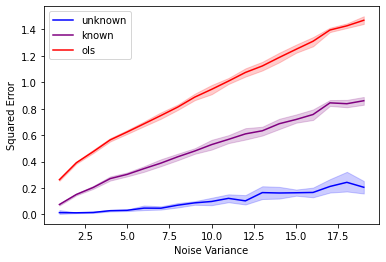

In [13]:
# plot results for regression parameter MSE
sns.lineplot(data=unknown, x='var', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=known, x='var', y='known_param_mse', label='known', color='purple')
ax = sns.lineplot(data=ols, x='var', y='ols_param_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error')
plt.show()
# close reader
reader.close()

In [21]:
store.close()

In [ ]:
print("hi")

In [9]:
store.close()